In [1]:
import os, glob
import copy
import numpy as np
import pandas as pd
# pd.set_option('display.max_rows', 250)
pd.set_option('display.max_columns', 200)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import rankdata
from scipy import stats
from datetime import datetime, timedelta

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import mixture
from math import pi
from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import PCA
from kneed import DataGenerator, KneeLocator

cwd = os.getcwd()
today = datetime.today().strftime('%Y-%m-%d')

print(cwd)
print(today)

/home/cst/SmartTradzt/Github/Price-Segmentation
2021-07-15


In [2]:
min_cluster = 3

In [3]:
filename = 'Polymer Spot Sales Contract v2.xlsx'
filepath = os.path.join(cwd,'InternalData',filename)
print(filepath)

/home/cst/SmartTradzt/Github/Price-Segmentation/InternalData/Polymer Spot Sales Contract v2.xlsx


In [4]:
data = pd.read_excel(filepath,sheet_name='Polymer Spot Sales Contract')

In [5]:
data['Price Premium Pctg'] = data['Price Premium']/data['REFERENCE_MARKET_PRICE']

In [6]:
data['Customer Industry'].fillna('No Customer Industry',inplace=True)
data['Customer Type'].fillna('No Customer Type',inplace=True)
data['Cross Boarder'].fillna('No Cross Boarder',inplace=True)

In [7]:
data.head()

,Contract Execution Date,PMT No.,Item No,Sales Contract No.,Contract/Spot,Sold to Customer Name,Sold to Customer Code,Customer Type,Customer Industry,Grade,Material,Payment Term,Incoterm,Country,Destination Port,City State,Shipping Condition,Export/Domestic,Cross Boarder,Plant,RETA,BL Date,EXCHANGE_RATE,QUANTITY,UOM,Currency,FLOOR_PRICE,NORMALISED_INVOICE_PRICE,REFERENCE_MARKET_PRICE,Price Premium,PRODUCTBASEPRICE,GRADEALPHA,INVOICEPRICE,Price Premium Pctg
0,2017-08-04,QTN-0000012192-1,1,30010898,QUOTATION,DURA-MINE SDN BHD.,8010000770,End Customer,Mfg-Petroleum Prod,HD5301AA,72000544,ZB30,DAP,Malaysia,MYSG00 KLANG VALLEY,MYSG00 KLANG VALLEY,TRUCK PACK(Drum),DOMESTIC,NONCROSSBORDER,M167,2017-08-08,2017-08-01,4.29,22.0,MT,USD,1070.0,1150.98423,1086.25,64.73423,1090.0,20.000000,1177.000000,0.059594
1,2017-11-22,QTN-0000013779-1,1,30012429,QUOTATION,CJ POLYMERS SDN. BHD.,8010000714,Distributor / Trader,Mfg-Petroleum Prod,C150Y,72000448,TT60SBLC,CFR,Bangladesh,BDCGP CHITTAGONG,NaN,MARINE PACK,EXPORT,NONCROSSBORDER,M059,2018-01-10,2018-01-03,4.22,306.0,MT,USD,1290.0,1235.58130,1288.75,-53.16870,1290.0,41.669931,1279.999931,-0.041256
2,2017-09-11,QTN-0000012648-1,1,30011297,QUOTATION,SUMIKENG (M) SDN BHD,8010001403,Distributor / Trader,Mfg-Petroleum Prod,HD5201AA,72000539,ZM60,DAP,Malaysia,MYPG04 PRAI,MYPG04 PRAI,TRUCK PACK(Drum),DOMESTIC,NONCROSSBORDER,M167,2017-09-30,2017-09-23,4.29,22.0,MT,USD,1170.0,1230.01552,1135.00,95.01552,1160.0,53.080955,1261.000955,0.083714
3,2017-05-15,QTN-0000010801-1,2,30009609,QUOTATION,ZHEJIANG FUTURE PETROCHEMICAL,8010001559,Distributor / Trader,Mfg-Petroleum Prod,C150Y,72000448,LC60,CFR,Hong Kong,HKHKG HONG KONG PORT,NaN,MARINE PACK,EXPORT,NONCROSSBORDER,M059,2017-05-31,2017-05-24,0.00,102.0,MT,USD,1190.0,1202.83563,1302.50,-99.66437,1310.0,78.407735,1207.002265,-0.076518
4,2018-08-06,QTN-0000018707-1,1,30016459,QUOTATION,CHONG WAH PLASTICS SDN BHD,8010000709,End Customer,Mfg-Petroleum Prod,LL0209SA,72000608,ZB60,DAP,Malaysia,MYKD01 ALOR SETAR,MYSG00 KLANG VALLEY,TRUCK PACK(Drum),DOMESTIC,NONCROSSBORDER,M167,2018-08-31,2018-08-24,4.04,180.0,MT,USD,1190.0,1312.38099,1181.25,131.13099,1210.0,21.566372,1336.996372,0.111010


<AxesSubplot:>

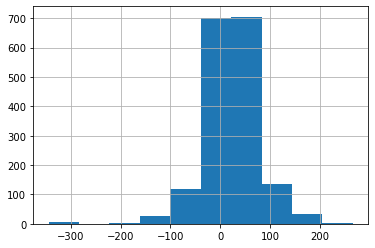

In [8]:
data[data['Currency']=='USD']['Price Premium'].hist()

<AxesSubplot:>

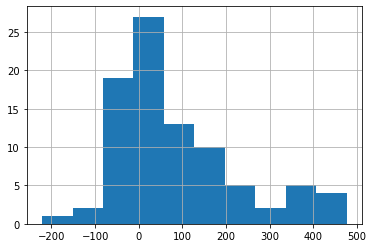

In [9]:
data[data['Currency']!='USD']['Price Premium'].hist()

# Customer Segmentation

## Customer

In [10]:
CustomerCode = data.groupby(['Sold to Customer Code']).aggregate({'Price Premium':np.max}).reset_index()
CustomerCode.rename(columns={'Price Premium':'Price Premium per Customer Code'},inplace=True)
CustomerCode

,Sold to Customer Code,Price Premium per Customer Code
0,8010000395,65.00000
1,8010000576,79.17108
2,8010000604,42.64534
3,8010000635,16.43652
4,8010000645,86.00000
...,...,...
143,8010007553,15.00000
144,8010007557,97.00000
145,8010007602,30.30342
146,8010007704,20.00000


In [11]:
Recency = data.groupby(['Sold to Customer Code']).aggregate({'Contract Execution Date':[pd.Series.nunique,np.max]}).reset_index()
Recency.columns = ['Sold to Customer Code','UniqueDays','MostRecentDate']
Recency['today'] = today
Recency['today'] = pd.to_datetime(Recency['today'])
Recency['MostRecentDate'] = pd.to_datetime(Recency['MostRecentDate'])
Recency['days_gap'] = (Recency['today']-Recency['MostRecentDate']).dt.days
Recency = Recency.loc[:,['Sold to Customer Code','UniqueDays','days_gap']]
Recency

,Sold to Customer Code,UniqueDays,days_gap
0,8010000395,1,847
1,8010000576,1,1525
2,8010000604,5,888
3,8010000635,3,433
4,8010000645,26,510
...,...,...,...
143,8010007553,1,693
144,8010007557,1,651
145,8010007602,7,400
146,8010007704,3,400


In [12]:
RFM = pd.merge(CustomerCode,Recency,on=['Sold to Customer Code'],how='inner')
RFM

,Sold to Customer Code,Price Premium per Customer Code,UniqueDays,days_gap
0,8010000395,65.00000,1,847
1,8010000576,79.17108,1,1525
2,8010000604,42.64534,5,888
3,8010000635,16.43652,3,433
4,8010000645,86.00000,26,510
...,...,...,...,...
143,8010007553,15.00000,1,693
144,8010007557,97.00000,1,651
145,8010007602,30.30342,7,400
146,8010007704,20.00000,3,400


## Industry

In [13]:
data['Customer Industry'].unique()

array(['Mfg-Petroleum Prod', 'Trading', 'Mfg-Chemical Product',
       'Mfg-Others', 'EPLS', 'No Customer Industry', 'Petrochemical'],
      dtype=object)

In [14]:
data['Customer Industry'].value_counts(dropna=False)

Mfg-Petroleum Prod      1430
Trading                  252
Mfg-Others                70
Mfg-Chemical Product      54
EPLS                       9
No Customer Industry       1
Petrochemical              1
Name: Customer Industry, dtype: int64

In [15]:
CustomerIndustry = data.groupby(['Customer Industry']).aggregate({'Price Premium':np.max}).reset_index()
CustomerIndustry.rename(columns={'Price Premium':'Price Premium per Customer Industry'},inplace=True)
CustomerIndustry

,Customer Industry,Price Premium per Customer Industry
0,EPLS,47.64103
1,Mfg-Chemical Product,179.03099
2,Mfg-Others,404.50201
3,Mfg-Petroleum Prod,475.67398
4,No Customer Industry,48.00000
5,Petrochemical,65.00000
6,Trading,107.50000


## Customer Type

In [16]:
data['Customer Type'].value_counts(dropna=False)

Distributor / Trader    1055
End Customer             758
No Customer Type           4
Name: Customer Type, dtype: int64

In [17]:
CustomerType = data.groupby(['Customer Type']).aggregate({'Price Premium':np.max}).reset_index()
CustomerType.rename(columns={'Price Premium':'Price Premium per CustomerType'},inplace=True)
CustomerType

,Customer Type,Price Premium per CustomerType
0,Distributor / Trader,411.46914
1,End Customer,475.67398
2,No Customer Type,47.25781


## Segmentation

In [18]:
customer_segmentation = data.copy()
customer_segmentation = customer_segmentation.loc[:,['Sold to Customer Code','Customer Type','Customer Industry']]
customer_segmentation.drop_duplicates(inplace=True)
customer_segmentation

,Sold to Customer Code,Customer Type,Customer Industry
0,8010000770,End Customer,Mfg-Petroleum Prod
1,8010000714,Distributor / Trader,Mfg-Petroleum Prod
2,8010001403,Distributor / Trader,Mfg-Petroleum Prod
3,8010001559,Distributor / Trader,Mfg-Petroleum Prod
4,8010000709,End Customer,Mfg-Petroleum Prod
...,...,...,...
1512,8010007185,Distributor / Trader,Mfg-Others
1516,8010001260,End Customer,Mfg-Petroleum Prod
1534,8010007432,End Customer,Mfg-Petroleum Prod
1570,8010001350,End Customer,Mfg-Petroleum Prod


In [19]:
X = pd.merge(customer_segmentation,RFM,on=['Sold to Customer Code'],how='inner')
X = pd.merge(X,CustomerIndustry,on=['Customer Industry'],how='inner')
X = pd.merge(X,CustomerType,on=['Customer Type'],how='inner')

In [20]:
X.shape

(148, 8)

In [21]:
features = ['Price Premium per Customer Code', 'UniqueDays', 'days_gap',
       'Price Premium per Customer Industry',
       'Price Premium per CustomerType']
X[features]

,Price Premium per Customer Code,UniqueDays,days_gap,Price Premium per Customer Industry,Price Premium per CustomerType
0,103.43304,8,1226,475.67398,475.67398
1,212.72594,24,888,475.67398,475.67398
2,86.00000,26,510,475.67398,475.67398
3,193.16124,10,833,475.67398,475.67398
4,266.50075,16,952,475.67398,475.67398
...,...,...,...,...,...
143,88.00000,10,414,404.50201,411.46914
144,152.78315,3,1168,404.50201,411.46914
145,-38.26534,1,904,404.50201,411.46914
146,20.00000,3,400,475.67398,47.25781


In [22]:
Scaler = StandardScaler()
X_std = Scaler.fit_transform(X[features])
X_std_df = pd.DataFrame(X_std,columns=features)

pca = PCA(random_state=42)
pca_scale = pca.fit_transform(X_std_df)
pca_scale_df = pd.DataFrame(pca_scale)
pca_scale_df.columns = ['PC_'+str(item) for item in pca_scale_df.columns]
pca_scale_df

,PC_0,PC_1,PC_2,PC_3,PC_4
0,-0.698616,-0.951377,0.289191,0.125187,0.584676
1,1.243794,-1.471823,-0.529905,0.243356,0.637202
2,1.646689,-0.368357,0.053876,-1.015561,0.423388
3,0.420527,-1.238136,-0.194034,0.295053,-0.316264
4,0.807614,-1.832659,-0.656474,0.802026,0.078819
...,...,...,...,...,...
143,1.017552,0.680240,0.274633,-0.007828,-0.701319
144,-0.569665,-0.289460,0.088363,1.300371,0.101828
145,-0.823504,1.160948,1.059764,-0.205261,0.044264
146,2.053375,4.694673,3.119943,4.287250,-0.446703


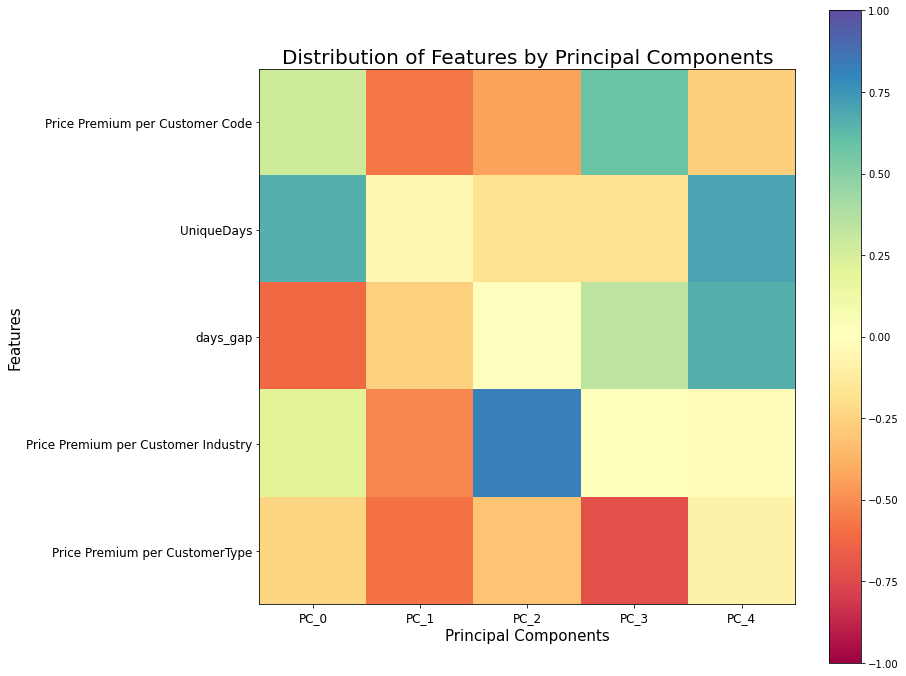

In [23]:
fig, ax = plt.subplots(figsize=(12, 12))
plt.imshow(pca.components_.T, cmap = 'Spectral', vmin =-1, vmax = 1)

plt.yticks(range(len(features)), features, fontsize=12)
plt.xticks(range(len(pca_scale_df.columns)), pca_scale_df.columns,fontsize=12)
plt.xlabel('Principal Components',
           fontsize=15)
plt.ylabel('Features',
           fontsize=15)
plt.title('Distribution of Features by Principal Components',
          fontsize=20)
plt.colorbar()
plt.show()


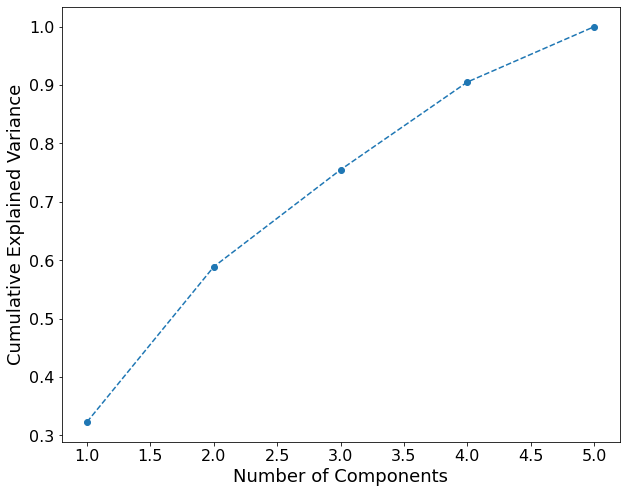

In [24]:
evr = pca.explained_variance_ratio_
var1 = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

fig = plt.figure(figsize=(10,8))
plt.plot(range(1, len(features)+1), evr.cumsum(), marker='o', linestyle='--')
plt.xlabel('Number of Components', fontsize=18)
plt.ylabel('Cumulative Explained Variance',fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# fig = plt.savefig("./visualizations/cumulative_variance_plot.png")
plt.show()

In [25]:
for i, exp_var in enumerate(evr.cumsum()):
    if exp_var >= 0.8:
        n_comps = i + 1
        break
print("Number of components:", n_comps)

Number of components: 4


In [26]:
pca_scale_df.iloc[:,0:n_comps]

,PC_0,PC_1,PC_2,PC_3
0,-0.698616,-0.951377,0.289191,0.125187
1,1.243794,-1.471823,-0.529905,0.243356
2,1.646689,-0.368357,0.053876,-1.015561
3,0.420527,-1.238136,-0.194034,0.295053
4,0.807614,-1.832659,-0.656474,0.802026
...,...,...,...,...
143,1.017552,0.680240,0.274633,-0.007828
144,-0.569665,-0.289460,0.088363,1.300371
145,-0.823504,1.160948,1.059764,-0.205261
146,2.053375,4.694673,3.119943,4.287250


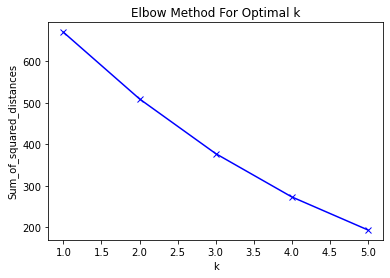

In [27]:
Sum_of_squared_distances = []
K = range(1,6)
for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km = km.fit(pca_scale_df.iloc[:,0:n_comps])
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()


In [28]:
kl = KneeLocator(range(1, 6), Sum_of_squared_distances, curve="convex", direction="decreasing")
print('Suggested number of clusters:',kl.elbow)

if kl.elbow is None or kl.elbow<min_cluster:
    n_clusters = min_cluster
else:
    n_clusters = kl.elbow
    
print('n_clusters:',n_clusters)


Suggested number of clusters: None
n_clusters: 3


/home/cst/anaconda3/lib/python3.8/site-packages/kneed/knee_locator.py:304: UserWarning: No knee/elbow found
  warnings.warn("No knee/elbow found")


In [29]:
clustering = KMeans(n_clusters=n_clusters, random_state=42).fit(pca_scale_df)

In [30]:
X['Cluster'] = clustering.labels_
X_std_df['Cluster'] = clustering.labels_
pca_scale_df['Cluster'] = clustering.labels_

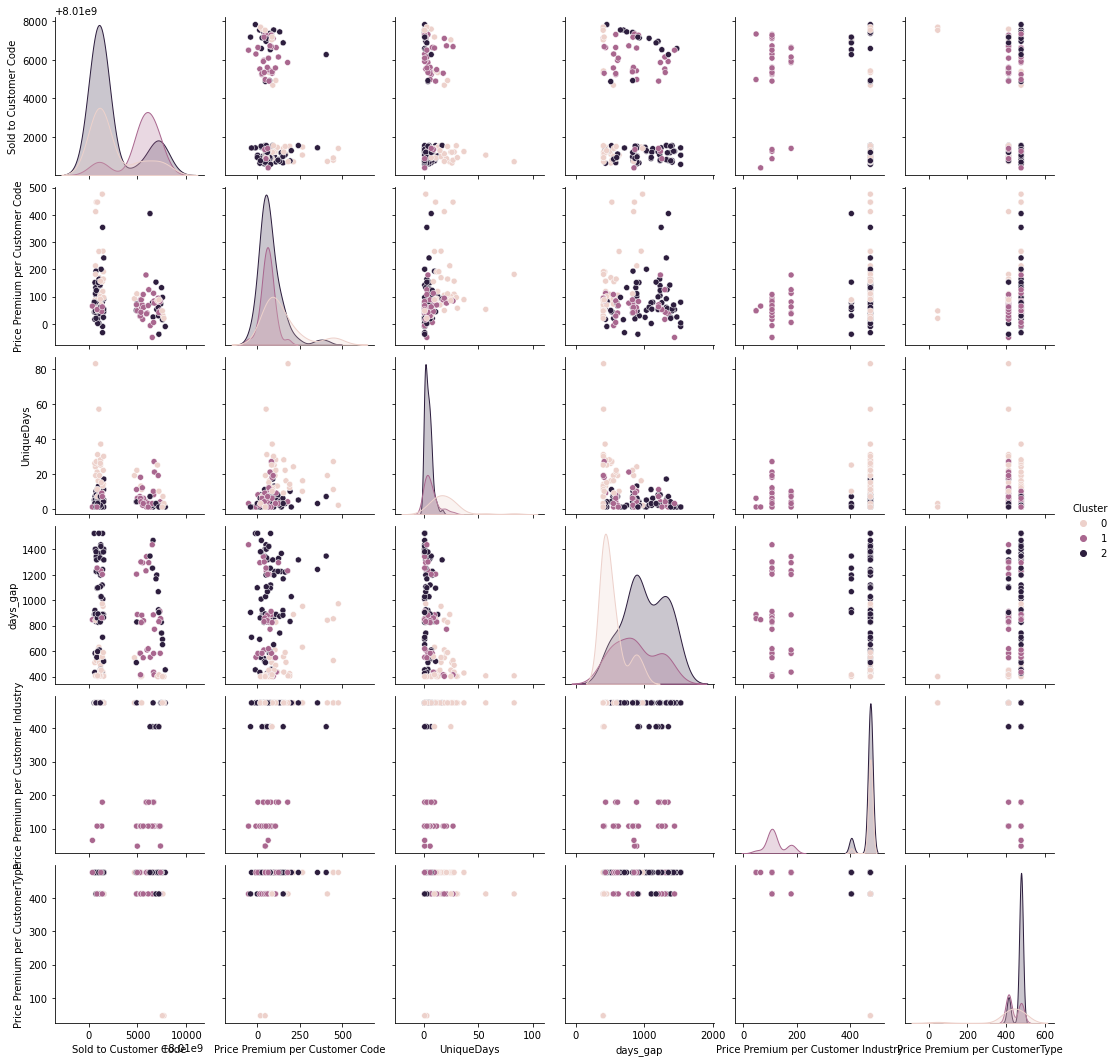

In [31]:
sns.pairplot(X,hue='Cluster')

In [32]:
X['Cluster'].value_counts()

2    75
0    39
1    34
Name: Cluster, dtype: int64

In [33]:
X['Cluster'].value_counts(normalize=True)

2    0.506757
0    0.263514
1    0.229730
Name: Cluster, dtype: float64

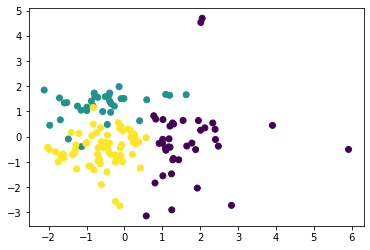

In [34]:
plt.scatter(pca_scale_df['PC_0'],pca_scale_df['PC_1'],c=pca_scale_df['Cluster'])

In [35]:
MinMax = MinMaxScaler()
X_MinMax = MinMax.fit_transform(X[features])
X_MinMax_df = pd.DataFrame(X_MinMax)
X_MinMax_df.columns = features
X_MinMax_df['Cluster'] = clustering.labels_
agg_median = X_MinMax_df.groupby('Cluster').median().reset_index()
agg_median

,Cluster,Price Premium per Customer Code,UniqueDays,days_gap,Price Premium per Customer Industry,Price Premium per CustomerType
0,0,0.278630,0.219512,0.031972,1.000000,0.850134
1,1,0.211324,0.036585,0.393428,0.139847,0.850134
2,2,0.206877,0.036585,0.461812,1.000000,1.000000


<b>There is clear distinction on Premium Price Distribution per Cluster</b>

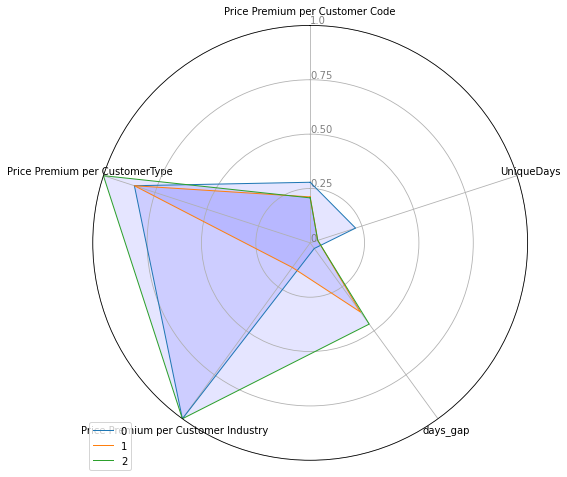

In [36]:
# number of variable
radar_features = features
N_features = len(radar_features)

# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N_features) * 2 * pi for n in range(N_features)]
angles += angles[:1]
    
# Initialise the spider plot
plt.figure(figsize=(36,8))
ax = plt.subplot(111, polar=True)
 
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels
plt.xticks(angles[:-1], radar_features)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([0,0.25,0.50,0.75,1], ["0","0.25","0.50","0.75","1.0"], color="grey", size=10)
plt.ylim(0,1)
 

for label in agg_median['Cluster']:
    
    # Ind
    values=agg_median[agg_median['Cluster']==label][['Cluster']+radar_features]
#     .drop('simple_cluster_4_label').values.flatten().tolist()
    del values['Cluster']
#     values.drop('simple_cluster_4_label')
#     .drop('simple_cluster_4_label').values.flatten().tolist()
#     print(type(values))
    values = values.values.flatten().tolist()
    
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=label)
    ax.fill(angles, values, 'b', alpha=0.1)


# Add legend
plt.legend(loc='best', bbox_to_anchor=(0.1, 0.1))

# Show the graph
plt.show()





In [37]:
X.rename(columns={'Cluster':'Customer Segment'},inplace=True)

In [38]:
X

,Sold to Customer Code,Customer Type,Customer Industry,Price Premium per Customer Code,UniqueDays,days_gap,Price Premium per Customer Industry,Price Premium per CustomerType,Customer Segment
0,8010000770,End Customer,Mfg-Petroleum Prod,103.43304,8,1226,475.67398,475.67398,2
1,8010000709,End Customer,Mfg-Petroleum Prod,212.72594,24,888,475.67398,475.67398,0
2,8010000645,End Customer,Mfg-Petroleum Prod,86.00000,26,510,475.67398,475.67398,0
3,8010000757,End Customer,Mfg-Petroleum Prod,193.16124,10,833,475.67398,475.67398,2
4,8010001477,End Customer,Mfg-Petroleum Prod,266.50075,16,952,475.67398,475.67398,0
...,...,...,...,...,...,...,...,...,...
143,8010007189,Distributor / Trader,Mfg-Others,88.00000,10,414,404.50201,411.46914,0
144,8010006888,Distributor / Trader,Mfg-Others,152.78315,3,1168,404.50201,411.46914,2
145,8010007185,Distributor / Trader,Mfg-Others,-38.26534,1,904,404.50201,411.46914,2
146,8010007704,No Customer Type,Mfg-Petroleum Prod,20.00000,3,400,475.67398,47.25781,0


In [39]:
company_segment = X[['Sold to Customer Code','Customer Type','Customer Industry','Customer Segment']]
company_segment

,Sold to Customer Code,Customer Type,Customer Industry,Customer Segment
0,8010000770,End Customer,Mfg-Petroleum Prod,2
1,8010000709,End Customer,Mfg-Petroleum Prod,0
2,8010000645,End Customer,Mfg-Petroleum Prod,0
3,8010000757,End Customer,Mfg-Petroleum Prod,2
4,8010001477,End Customer,Mfg-Petroleum Prod,0
...,...,...,...,...
143,8010007189,Distributor / Trader,Mfg-Others,0
144,8010006888,Distributor / Trader,Mfg-Others,2
145,8010007185,Distributor / Trader,Mfg-Others,2
146,8010007704,No Customer Type,Mfg-Petroleum Prod,0


In [40]:
company_segment['Customer Segment'].value_counts()

2    75
0    39
1    34
Name: Customer Segment, dtype: int64

In [41]:
company_segment.to_csv('company_segment_v3B.csv',index=False)

# Product & Transaction Segmentation

In [42]:
data.head()

,Contract Execution Date,PMT No.,Item No,Sales Contract No.,Contract/Spot,Sold to Customer Name,Sold to Customer Code,Customer Type,Customer Industry,Grade,Material,Payment Term,Incoterm,Country,Destination Port,City State,Shipping Condition,Export/Domestic,Cross Boarder,Plant,RETA,BL Date,EXCHANGE_RATE,QUANTITY,UOM,Currency,FLOOR_PRICE,NORMALISED_INVOICE_PRICE,REFERENCE_MARKET_PRICE,Price Premium,PRODUCTBASEPRICE,GRADEALPHA,INVOICEPRICE,Price Premium Pctg
0,2017-08-04,QTN-0000012192-1,1,30010898,QUOTATION,DURA-MINE SDN BHD.,8010000770,End Customer,Mfg-Petroleum Prod,HD5301AA,72000544,ZB30,DAP,Malaysia,MYSG00 KLANG VALLEY,MYSG00 KLANG VALLEY,TRUCK PACK(Drum),DOMESTIC,NONCROSSBORDER,M167,2017-08-08,2017-08-01,4.29,22.0,MT,USD,1070.0,1150.98423,1086.25,64.73423,1090.0,20.000000,1177.000000,0.059594
1,2017-11-22,QTN-0000013779-1,1,30012429,QUOTATION,CJ POLYMERS SDN. BHD.,8010000714,Distributor / Trader,Mfg-Petroleum Prod,C150Y,72000448,TT60SBLC,CFR,Bangladesh,BDCGP CHITTAGONG,NaN,MARINE PACK,EXPORT,NONCROSSBORDER,M059,2018-01-10,2018-01-03,4.22,306.0,MT,USD,1290.0,1235.58130,1288.75,-53.16870,1290.0,41.669931,1279.999931,-0.041256
2,2017-09-11,QTN-0000012648-1,1,30011297,QUOTATION,SUMIKENG (M) SDN BHD,8010001403,Distributor / Trader,Mfg-Petroleum Prod,HD5201AA,72000539,ZM60,DAP,Malaysia,MYPG04 PRAI,MYPG04 PRAI,TRUCK PACK(Drum),DOMESTIC,NONCROSSBORDER,M167,2017-09-30,2017-09-23,4.29,22.0,MT,USD,1170.0,1230.01552,1135.00,95.01552,1160.0,53.080955,1261.000955,0.083714
3,2017-05-15,QTN-0000010801-1,2,30009609,QUOTATION,ZHEJIANG FUTURE PETROCHEMICAL,8010001559,Distributor / Trader,Mfg-Petroleum Prod,C150Y,72000448,LC60,CFR,Hong Kong,HKHKG HONG KONG PORT,NaN,MARINE PACK,EXPORT,NONCROSSBORDER,M059,2017-05-31,2017-05-24,0.00,102.0,MT,USD,1190.0,1202.83563,1302.50,-99.66437,1310.0,78.407735,1207.002265,-0.076518
4,2018-08-06,QTN-0000018707-1,1,30016459,QUOTATION,CHONG WAH PLASTICS SDN BHD,8010000709,End Customer,Mfg-Petroleum Prod,LL0209SA,72000608,ZB60,DAP,Malaysia,MYKD01 ALOR SETAR,MYSG00 KLANG VALLEY,TRUCK PACK(Drum),DOMESTIC,NONCROSSBORDER,M167,2018-08-31,2018-08-24,4.04,180.0,MT,USD,1190.0,1312.38099,1181.25,131.13099,1210.0,21.566372,1336.996372,0.111010


## Grade

In [43]:
data['Grade'].value_counts(dropna=False)

C150Y       1022
HD5301AA     265
LL0209SA     171
M022X        113
LL3840UA     108
HD5201AA     106
N109X         32
Name: Grade, dtype: int64

In [44]:
data['Grade'].value_counts(dropna=False, normalize=True)

C150Y       0.562466
HD5301AA    0.145845
LL0209SA    0.094111
M022X       0.062190
LL3840UA    0.059439
HD5201AA    0.058338
N109X       0.017611
Name: Grade, dtype: float64

In [45]:
col = 'Grade'
GradePricePremium = data.groupby([col]).aggregate({'Price Premium':np.max}).reset_index()
GradePricePremium.rename(columns={'Price Premium':'Price Premium per Grade'},inplace=True)
GradePricePremium

,Grade,Price Premium per Grade
0,C150Y,446.36763
1,HD5201AA,169.20257
2,HD5301AA,138.64267
3,LL0209SA,266.50075
4,LL3840UA,200.20391
5,M022X,475.67398
6,N109X,110.71677


## Material

In [46]:
data['Material'].value_counts(dropna=False)

72000448    1022
72000544     265
72000608     171
72000628     113
72000617     108
72000539     106
72000660      32
Name: Material, dtype: int64

In [47]:
data['Material'].value_counts(dropna=False, normalize=True)

72000448    0.562466
72000544    0.145845
72000608    0.094111
72000628    0.062190
72000617    0.059439
72000539    0.058338
72000660    0.017611
Name: Material, dtype: float64

In [48]:
col = 'Material'
MaterialPricePremium = data.groupby([col]).aggregate({'Price Premium':np.max}).reset_index()
MaterialPricePremium.rename(columns={'Price Premium':'Price Premium per Material'},inplace=True)
MaterialPricePremium

,Material,Price Premium per Material
0,72000448,446.36763
1,72000539,169.20257
2,72000544,138.64267
3,72000608,266.50075
4,72000617,200.20391
5,72000628,475.67398
6,72000660,110.71677


## Payment Term

In [49]:
# data['Payment Term'].value_counts(dropna=False)

In [50]:
# col = 'Payment Term'
# PaymentTermPricePremium = data[[col,'Price Premium']].groupby([col]).quantile([0.01,0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 0.99, 1]).reset_index()
# PaymentTermPricePremium = pd.pivot_table(PaymentTermPricePremium, values='Price Premium',index=[col],columns='level_1').reset_index() 

# prefix = 'PricePremiumPer'+col.replace(' ','')+'Percentile_'
# PaymentTermPricePremium.columns = [col if 'str' in str(type(col)) else str(prefix)+str(col) for col in PaymentTermPricePremium.columns ]
# PaymentTermPricePremium

## Incoterm

In [51]:
# data['Incoterm'].value_counts(dropna=False)

In [52]:
# IncotermMapping = {
#                         'EXW':1,
#                         'FCA':2,
#                         'FAS':3,
#                         'FOB':4,
#                         'CFR':5,
#                         'CIF':5.5,
#                         'CPT':6,
#                         'CIP':6.25,
#                         'DAT':6.50,
#                         'DAP':6.75,
#                         'DDP':7,
#                     }

In [53]:
# col = 'Incoterm'
# IncotermPricePremium = data[[col,'Price Premium']].groupby([col]).quantile([0.01,0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 0.99, 1]).reset_index()
# IncotermPricePremium = pd.pivot_table(IncotermPricePremium, values='Price Premium',index=[col],columns='level_1').reset_index() 

# prefix = 'PricePremiumPer'+col.replace(' ','')+'Percentile_'
# IncotermPricePremium.columns = [col if 'str' in str(type(col)) else str(prefix)+str(col) for col in IncotermPricePremium.columns ]
# IncotermPricePremium

## Country

In [54]:
data['Country'].unique()

array(['Malaysia', 'Bangladesh', 'Hong Kong', 'China', 'Philippines',
       'Taiwan', 'Thailand', 'Japan', 'Vietnam', 'India', 'Indonesia',
       'Australia', 'Peru', 'Myanmar', 'South Korea', 'Singapore',
       'South Africa', 'Ghana', 'Turkey', 'Pakistan', 'Kenya',
       'Russian Fed.'], dtype=object)

In [55]:
data['Country'].value_counts(dropna=False)

Malaysia        676
Thailand        246
China           208
Indonesia       176
Bangladesh      156
Philippines     131
Vietnam          60
Taiwan           50
India            33
Hong Kong        29
Japan            11
South Africa     10
Myanmar           9
South Korea       5
Singapore         4
Pakistan          3
Australia         3
Ghana             3
Russian Fed.      1
Peru              1
Kenya             1
Turkey            1
Name: Country, dtype: int64

In [56]:
col = 'Country'
CountryPricePremium = data.groupby([col]).aggregate({'Price Premium':np.max}).reset_index()
CountryPricePremium.rename(columns={'Price Premium':'Price Premium per Country'},inplace=True)
CountryPricePremium

,Country,Price Premium per Country
0,Australia,53.75726
1,Bangladesh,116.87500
2,China,132.50000
3,Ghana,70.23453
4,Hong Kong,13.48438
5,India,60.00000
6,Indonesia,179.03099
7,Japan,111.98493
8,Kenya,16.66667
9,Malaysia,446.36763


In [60]:
GNI = pd.read_csv('GNI.csv')

In [61]:
GNI

,Rank,Country,Alias,GNI per capita (US$),Year,Group,Group Rank
0,56,Romania,Romania,12570.0,2020.0,Upper-middle-income,3
1,57,Panama,Panama,11880.0,2020.0,Upper-middle-income,3
2,—,World,World,11558.0,2019.0,Upper-middle-income,3
3,58,Costa Rica,Costa Rica,11460.0,2020.0,Upper-middle-income,3
4,59,Russia,Russian Fed.,10690.0,2020.0,Upper-middle-income,3
...,...,...,...,...,...,...,...
213,52,Croatia,Croatia,14190.0,2020.0,High-income,4
214,53,Oman,Oman,14150.0,2019.0,High-income,4
215,—,New Caledonia (France),New Caledonia (France),14020.0,2000.0,High-income,4
216,54,Chile,Chile,13470.0,2020.0,High-income,4


In [62]:
CountryPricePremium = pd.merge(CountryPricePremium,GNI,left_on='Country',right_on='Alias',how='left')

In [63]:
CountryPricePremium.head()

,Country_x,Price Premium per Country,Rank,Country_y,Alias,GNI per capita (US$),Year,Group,Group Rank
0,Australia,53.75726,12,Australia,Australia,53730.0,2020.0,High-income,4.0
1,Bangladesh,116.87500,141,Bangladesh,Bangladesh,2010.0,2020.0,Lower-middle-income,2.0
2,China,132.50000,60,China,China,10610.0,2020.0,Upper-middle-income,3.0
3,Ghana,70.23453,137,Ghana,Ghana,2230.0,2020.0,Lower-middle-income,2.0
4,Hong Kong,13.48438,—,Hong Kong (China),Hong Kong,48630.0,2020.0,High-income,4.0


In [64]:
cols = ['Rank','Country_y','Alias','Year','Group']

for col in cols:

    if col in CountryPricePremium.columns:
        del CountryPricePremium[col]
    
    

In [65]:
CountryPricePremium.rename(columns={'Country_x':'Country'},inplace=True)

In [66]:
MedianIncomeGroup = CountryPricePremium.groupby(['Group Rank']).aggregate({'GNI per capita (US$)':np.median}).reset_index()
MedianIncomeGroup

,Group Rank,GNI per capita (US$)
0,2.0,2010.0
1,3.0,9050.0
2,4.0,48630.0


In [67]:
CountryPricePremium.loc[CountryPricePremium['Country']=='Taiwan','GNI per capita (US$)'] = 48630.0
# CountryPricePremium.loc[CountryPricePremium['Country']=='Taiwan','Group'] = 'High-income'
CountryPricePremium.loc[CountryPricePremium['Country']=='Taiwan','Group Rank'] = 4

In [68]:
CountryPricePremium

,Country,Price Premium per Country,GNI per capita (US$),Group Rank
0,Australia,53.75726,53730.0,4.0
1,Bangladesh,116.87500,2010.0,2.0
2,China,132.50000,10610.0,3.0
3,Ghana,70.23453,2230.0,2.0
4,Hong Kong,13.48438,48630.0,4.0
5,India,60.00000,1900.0,2.0
6,Indonesia,179.03099,3870.0,2.0
7,Japan,111.98493,41580.0,4.0
8,Kenya,16.66667,1760.0,2.0
9,Malaysia,446.36763,10580.0,3.0


## Destination Port

In [69]:
data['Destination Port'].isnull().sum()

0

In [70]:
data['Destination Port'].value_counts(dropna=False)

MYKD01 ALOR SETAR        524
INDONESIA MAIN PORT      172
THBKK BANGKOK            164
BDCGP CHITTAGONG         154
PHMNL MANILA             111
CHINA MAIN PORT          103
MYSG00 KLANG VALLEY       96
THAYU AYUTHAYA            76
CNYTN YANTIAN             42
VNSGN HO CHI MINH         36
HKHKG HONG KONG PORT      29
CNNGB NINGBO              22
VNHAP HAI PHONG           22
MYPG06 PENANG             20
MYPG04 PRAI               19
PHDVO DAVAO               19
INNSA NHAVA SHEVA         18
TAIWAN MAIN PORTS         17
CNSHA SHANGHAI            16
INCCU KOLKATA             14
TWTXG TAICHUNG            13
KAOHSIUNG                 11
ZADUR DURBAN              10
MMRGN YANGON               9
CNHUA HUANGPUSUIGANG       9
TWKEL KEELUNG              9
JPHTD HAKATA               8
THBRK BANGRAK              6
MYMK01 MELAKA              5
KRICE INCHEON              5
CNSWA SHANTOU              4
MYPR16 KAMUNTING           4
MYKD05 GURUN               4
HUANGPU NEW PORT           4
PKKHI KARACHI 

In [71]:
col = 'Destination Port'
DestinationPortPricePremium = data.groupby([col]).aggregate({'Price Premium':np.max}).reset_index()
DestinationPortPricePremium.rename(columns={'Price Premium':'Price Premium per Destination Port'},inplace=True)
DestinationPortPricePremium

,Destination Port,Price Premium per Destination Port
0,"ANY PORT, PERU",-15.81658
1,AUMEL MELBOURNE,53.75726
2,AUSYD SYDNEY,53.75726
3,BANGLADESH,-0.18370
4,BDCGP CHITTAGONG,116.87500
5,CHINA MAIN PORT,69.87675
6,CNHUA HUANGPUSUIGANG,92.08849
7,CNNGB NINGBO,88.00000
8,CNSHA SHANGHAI,88.00000
9,CNSHK SHEKOU,132.50000


## Shipping Condition

In [72]:
data['Shipping Condition'].isnull().sum()

0

In [73]:
col = 'Shipping Condition'
ShippingConditionPricePremium = data.groupby([col]).aggregate({'Price Premium':np.max}).reset_index()
ShippingConditionPricePremium.rename(columns={'Price Premium':'Price Premium per Shipping Condition'},inplace=True)
ShippingConditionPricePremium

,Shipping Condition,Price Premium per Shipping Condition
0,MARINE PACK,181.41252
1,TRUCK PACK(Drum),475.67398


## Export/Domestic

In [74]:
data['Export/Domestic'].isnull().sum()

0

In [75]:
col = 'Export/Domestic'
ExportDomesticPricePremium = data.groupby([col]).aggregate({'Price Premium':np.max}).reset_index()
ExportDomesticPricePremium.rename(columns={'Price Premium':'Price Premium per Export/Domestic'},inplace=True)
ExportDomesticPricePremium

,Export/Domestic,Price Premium per Export/Domestic
0,DOMESTIC,446.36763
1,EXPORT,475.67398


## Cross Boarder

In [76]:
data['Cross Boarder'].unique()

array(['NONCROSSBORDER', 'CROSSBORDER', 'No Cross Boarder'], dtype=object)

In [77]:
col = 'Cross Boarder'
CrossBorderPricePremium = data.groupby([col]).aggregate({'Price Premium':np.max}).reset_index()
CrossBorderPricePremium.rename(columns={'Price Premium':'Price Premium per Cross Border'},inplace=True)
CrossBorderPricePremium

,Cross Boarder,Price Premium per Cross Border
0,CROSSBORDER,475.67398
1,NONCROSSBORDER,446.36763
2,No Cross Boarder,58.75000


## Plant

In [78]:
# data['Plant'].isnull().sum()

In [79]:
# col = 'Plant'
# PlantPricePremium = data[[col,'Price Premium']].groupby([col]).quantile([0.01,0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 0.99, 1]).reset_index()
# PlantPricePremium = pd.pivot_table(PlantPricePremium, values='Price Premium',index=[col],columns='level_1').reset_index() 

# prefix = 'PricePremiumPer'+col.replace(' ','').replace('/','')+'Percentile_'
# PlantPricePremium.columns = [col if 'str' in str(type(col)) else str(prefix)+str(col) for col in PlantPricePremium.columns ]
# PlantPricePremium

## Quantity

In [80]:
data['QUANTITY'].isnull().sum()

0

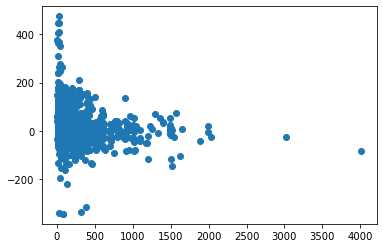

In [81]:
plt.scatter(data['QUANTITY'],data['Price Premium'])

## Grade Alpha

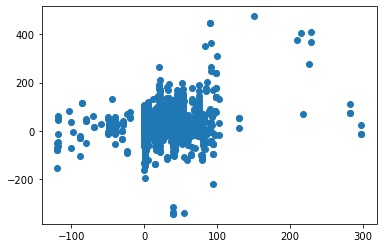

In [82]:
plt.scatter(data['GRADEALPHA'],data['Price Premium'])

## Segmentation

In [83]:
transaction_segmentation = data.copy()
transaction_segmentation.shape

(1817, 34)

In [84]:
transaction_segmentation = pd.merge(transaction_segmentation,GradePricePremium,on=['Grade'],how='inner')
transaction_segmentation = pd.merge(transaction_segmentation,MaterialPricePremium,on=['Material'],how='inner')
# transaction_segmentation = pd.merge(transaction_segmentation,PaymentTermPricePremium,left_on=['Payment Term'],right_on=['Payment Term'],how='inner')
# transaction_segmentation['IncotermLevel'] = transaction_segmentation['Incoterm'].map(IncotermMapping)
# transaction_segmentation = pd.merge(transaction_segmentation,IncotermPricePremium,on=['Incoterm'],how='inner')
transaction_segmentation = pd.merge(transaction_segmentation,CountryPricePremium,on=['Country'],how='inner')
transaction_segmentation = pd.merge(transaction_segmentation,DestinationPortPricePremium,on=['Destination Port'],how='inner')
transaction_segmentation = pd.merge(transaction_segmentation,ShippingConditionPricePremium,on=['Shipping Condition'],how='inner')
transaction_segmentation = pd.merge(transaction_segmentation,ExportDomesticPricePremium,on=['Export/Domestic'],how='inner')
transaction_segmentation = pd.merge(transaction_segmentation,CrossBorderPricePremium,on=['Cross Boarder'],how='inner')
# transaction_segmentation = pd.merge(transaction_segmentation,PlantPricePremium,left_on=['Plant'],right_on=['Plant'],how='inner')
transaction_segmentation.shape

(1817, 43)

In [85]:
transaction_segmentation.head()

,Contract Execution Date,PMT No.,Item No,Sales Contract No.,Contract/Spot,Sold to Customer Name,Sold to Customer Code,Customer Type,Customer Industry,Grade,Material,Payment Term,Incoterm,Country,Destination Port,City State,Shipping Condition,Export/Domestic,Cross Boarder,Plant,RETA,BL Date,EXCHANGE_RATE,QUANTITY,UOM,Currency,FLOOR_PRICE,NORMALISED_INVOICE_PRICE,REFERENCE_MARKET_PRICE,Price Premium,PRODUCTBASEPRICE,GRADEALPHA,INVOICEPRICE,Price Premium Pctg,Price Premium per Grade,Price Premium per Material,Price Premium per Country,GNI per capita (US$),Group Rank,Price Premium per Destination Port,Price Premium per Shipping Condition,Price Premium per Export/Domestic,Price Premium per Cross Border
0,2017-08-04,QTN-0000012192-1,1,30010898,QUOTATION,DURA-MINE SDN BHD.,8010000770,End Customer,Mfg-Petroleum Prod,HD5301AA,72000544,ZB30,DAP,Malaysia,MYSG00 KLANG VALLEY,MYSG00 KLANG VALLEY,TRUCK PACK(Drum),DOMESTIC,NONCROSSBORDER,M167,2017-08-08,2017-08-01,4.29,22.0,MT,USD,1070.0,1150.98423,1086.25,64.73423,1090.0,20.000000,1177.000000,0.059594,138.64267,138.64267,446.36763,10580.0,3.0,411.46914,475.67398,446.36763,446.36763
1,2018-03-07,QTN-0000015960-1,3,30013989,QUOTATION,COMMERCIAL PLASTIC INDUSTRIES,8010000729,Distributor / Trader,Mfg-Petroleum Prod,HD5301AA,72000544,ZM60,DAP,Malaysia,MYSG00 KLANG VALLEY,MYSG00 KLANG VALLEY,TRUCK PACK(Drum),DOMESTIC,NONCROSSBORDER,M167,2018-03-13,2018-03-06,3.90,572.0,MT,USD,1340.0,1403.21349,1401.25,1.96349,1360.0,23.521096,1430.001096,0.001401,138.64267,138.64267,446.36763,10580.0,3.0,411.46914,475.67398,446.36763,446.36763
2,2017-09-11,QTN-0000012629-1,1,30011296,QUOTATION,KAMMA KLANG ENTERPRISE SDN BHD,8010000960,End Customer,Mfg-Petroleum Prod,HD5301AA,72000544,ZCBD,DAP,Malaysia,MYSG00 KLANG VALLEY,MYSG00 KLANG VALLEY,TRUCK PACK(Drum),DOMESTIC,NONCROSSBORDER,M167,2017-09-14,2017-09-07,4.29,22.0,MT,USD,1140.0,1189.09195,1135.00,54.09195,1160.0,20.000000,1212.000000,0.047658,138.64267,138.64267,446.36763,10580.0,3.0,411.46914,475.67398,446.36763,446.36763
3,2018-03-06,QTN-0000015921-1,4,30013967,QUOTATION,CJ POLYMERS SDN. BHD.,8010000714,Distributor / Trader,Mfg-Petroleum Prod,HD5301AA,72000544,ZB60,DAP,Malaysia,MYSG00 KLANG VALLEY,MYSG00 KLANG VALLEY,TRUCK PACK(Drum),DOMESTIC,NONCROSSBORDER,M167,2018-03-31,2018-03-24,3.90,1100.0,MT,USD,1340.0,1405.06411,1401.25,3.81411,1360.0,21.760548,1430.000548,0.002722,138.64267,138.64267,446.36763,10580.0,3.0,411.46914,475.67398,446.36763,446.36763
4,2018-03-08,QTN-0000016042-1,1,30014047,QUOTATION,WT PLASTIC PRODUCTS SDN BHD,8010001548,End Customer,Mfg-Petroleum Prod,HD5301AA,72000544,ZB60,DAP,Malaysia,MYSG00 KLANG VALLEY,MYSG00 KLANG VALLEY,TRUCK PACK(Drum),DOMESTIC,NONCROSSBORDER,M167,2018-03-09,2018-03-02,3.90,726.0,MT,USD,1340.0,1405.06411,1401.25,3.81411,1360.0,21.760548,1430.000548,0.002722,138.64267,138.64267,446.36763,10580.0,3.0,411.46914,475.67398,446.36763,446.36763


In [86]:
list(transaction_segmentation.columns)

['Contract Execution Date',
 'PMT No.',
 'Item No',
 'Sales Contract No.',
 'Contract/Spot',
 'Sold to Customer Name',
 'Sold to Customer Code',
 'Customer Type',
 'Customer Industry',
 'Grade',
 'Material',
 'Payment Term',
 'Incoterm',
 'Country',
 'Destination Port',
 'City State',
 'Shipping Condition',
 'Export/Domestic',
 'Cross Boarder',
 'Plant',
 'RETA',
 'BL Date',
 'EXCHANGE_RATE',
 'QUANTITY',
 'UOM',
 'Currency',
 'FLOOR_PRICE',
 'NORMALISED_INVOICE_PRICE',
 'REFERENCE_MARKET_PRICE',
 'Price Premium',
 'PRODUCTBASEPRICE',
 'GRADEALPHA',
 'INVOICEPRICE',
 'Price Premium Pctg',
 'Price Premium per Grade',
 'Price Premium per Material',
 'Price Premium per Country',
 'GNI per capita (US$)',
 'Group Rank',
 'Price Premium per Destination Port',
 'Price Premium per Shipping Condition',
 'Price Premium per Export/Domestic',
 'Price Premium per Cross Border']

In [87]:
features = ['QUANTITY','GRADEALPHA','Price Premium per Grade',
 'Price Premium per Material',
 'Price Premium per Country',
 'GNI per capita (US$)',
 'Group Rank',
 'Price Premium per Destination Port',
 'Price Premium per Shipping Condition',
 'Price Premium per Export/Domestic',
 'Price Premium per Cross Border']

In [88]:
X = transaction_segmentation[features]

In [89]:
X.isnull().sum().sum()

0

In [90]:
X

,QUANTITY,GRADEALPHA,Price Premium per Grade,Price Premium per Material,Price Premium per Country,GNI per capita (US$),Group Rank,Price Premium per Destination Port,Price Premium per Shipping Condition,Price Premium per Export/Domestic,Price Premium per Cross Border
0,22.0,20.000000,138.64267,138.64267,446.36763,10580.0,3.0,411.46914,475.67398,446.36763,446.36763
1,572.0,23.521096,138.64267,138.64267,446.36763,10580.0,3.0,411.46914,475.67398,446.36763,446.36763
2,22.0,20.000000,138.64267,138.64267,446.36763,10580.0,3.0,411.46914,475.67398,446.36763,446.36763
3,1100.0,21.760548,138.64267,138.64267,446.36763,10580.0,3.0,411.46914,475.67398,446.36763,446.36763
4,726.0,21.760548,138.64267,138.64267,446.36763,10580.0,3.0,411.46914,475.67398,446.36763,446.36763
...,...,...,...,...,...,...,...,...,...,...,...
1812,17.0,0.000000,475.67398,475.67398,179.03099,3870.0,2.0,179.03099,181.41252,475.67398,58.75000
1813,51.0,40.000000,446.36763,446.36763,60.00000,1900.0,2.0,50.00000,181.41252,475.67398,58.75000
1814,210.0,40.965714,446.36763,446.36763,60.00000,1900.0,2.0,50.00000,181.41252,475.67398,58.75000
1815,17.0,30.000000,475.67398,475.67398,111.98493,41580.0,4.0,111.98493,181.41252,475.67398,58.75000


In [91]:
Scaler = StandardScaler()
X_std = Scaler.fit_transform(X)

pca = PCA(random_state=42)
pca_scale = pca.fit_transform(X_std)
pca_scale_df = pd.DataFrame(pca_scale)
pca_scale_df.columns = ['PC_'+str(item) for item in pca_scale_df.columns]
pca_scale_df


,PC_0,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10
0,3.226685,0.279973,0.663634,0.114510,-0.656830,-0.444161,-0.025429,0.044516,0.017927,0.000915,-3.526376e-17
1,3.065190,0.804981,1.421507,-0.484909,0.492463,0.628976,0.019148,0.110831,0.033964,-0.053987,-2.100631e-17
2,3.226685,0.279973,0.663634,0.114510,-0.656830,-0.444161,-0.025429,0.044516,0.017927,0.000915,3.822710e-15
3,2.889124,1.315602,2.216256,-1.066705,1.484304,1.707941,0.059478,0.185681,0.040937,-0.106276,3.985882e-17
4,3.008736,0.955516,1.669608,-0.656141,0.754707,0.955501,0.030313,0.135376,0.033954,-0.069137,-2.799482e-17
...,...,...,...,...,...,...,...,...,...,...,...
1812,-2.279905,1.980073,2.452713,15.866215,1.554916,2.928166,1.378350,0.616931,-1.149014,0.469807,-2.033023e-17
1813,-2.633479,2.107971,2.303909,15.828465,2.559926,2.064980,1.821935,0.932313,-0.837806,-0.032213,-2.804754e-17
1814,-2.680379,2.259813,2.523685,15.655114,2.891044,2.375710,1.834796,0.951597,-0.833256,-0.048080,-2.259984e-17
1815,-1.690199,-2.821909,4.162828,15.743055,3.057724,2.558446,1.454334,0.388718,-1.129252,0.331387,4.072805e-17


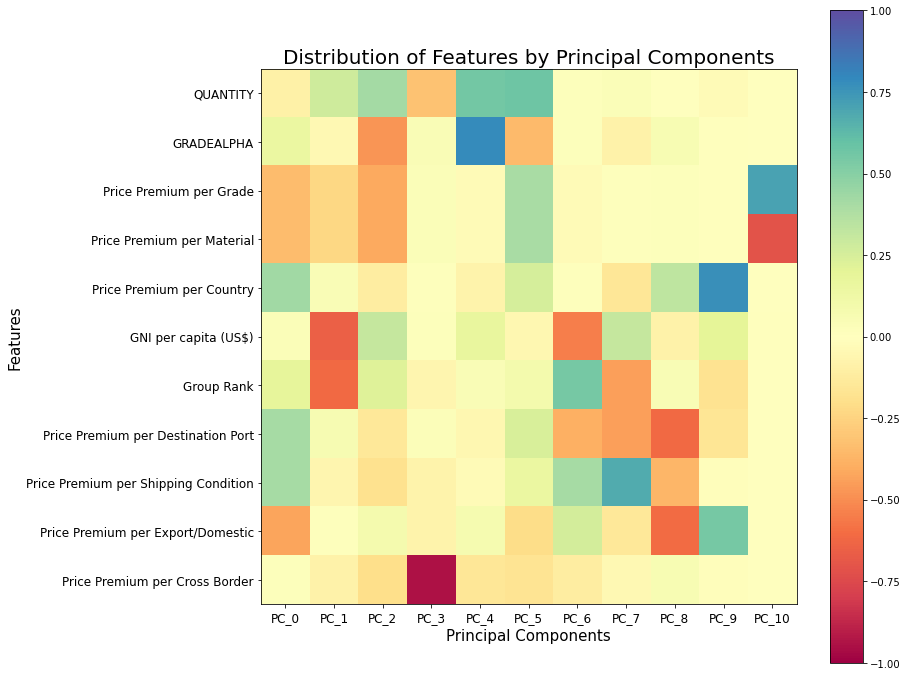

In [92]:
fig, ax = plt.subplots(figsize=(12, 12))
plt.imshow(pca.components_.T, cmap = 'Spectral', vmin =-1, vmax = 1)

plt.yticks(range(len(features)), features, fontsize=12)
plt.xticks(range(len(pca_scale_df.columns)), pca_scale_df.columns,fontsize=12)
plt.xlabel('Principal Components',
           fontsize=15)
plt.ylabel('Features',
           fontsize=15)
plt.title('Distribution of Features by Principal Components',
          fontsize=20)
plt.colorbar()
plt.show()


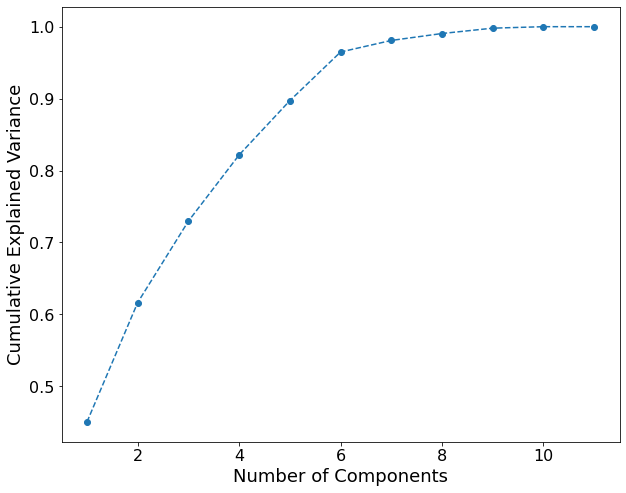

In [93]:
evr = pca.explained_variance_ratio_
var1 = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

fig = plt.figure(figsize=(10,8))
plt.plot(range(1, len(features)+1), evr.cumsum(), marker='o', linestyle='--')
plt.xlabel('Number of Components', fontsize=18)
plt.ylabel('Cumulative Explained Variance',fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# fig = plt.savefig("./visualizations/cumulative_variance_plot.png")
plt.show()

In [94]:
for i, exp_var in enumerate(evr.cumsum()):
    if exp_var >= 0.8:
        n_comps = i + 1
        break
print("Number of components:", n_comps)

Number of components: 4


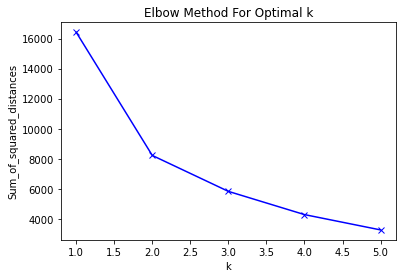

In [95]:
Sum_of_squared_distances = []
K = range(1,6)
for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km = km.fit(pca_scale_df.iloc[:,0:n_comps])
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()


In [96]:
kl = KneeLocator(range(1, 6), Sum_of_squared_distances, curve="convex", direction="decreasing")
print('Suggested number of clusters:',kl.elbow)

if kl.elbow is None or kl.elbow<min_cluster:
    n_clusters = min_cluster
else:
    n_clusters = kl.elbow
    
print('n_clusters:',n_clusters)


Suggested number of clusters: 2
n_clusters: 3


In [97]:
clustering = KMeans(n_clusters=n_clusters, random_state=42).fit(pca_scale_df)

In [98]:
X['transaction_cluster'] = clustering.labels_

<ipython-input-98-7c4d90d18657>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['transaction_cluster'] = clustering.labels_


/home/cst/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/cst/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/cst/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/cst/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/cst/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


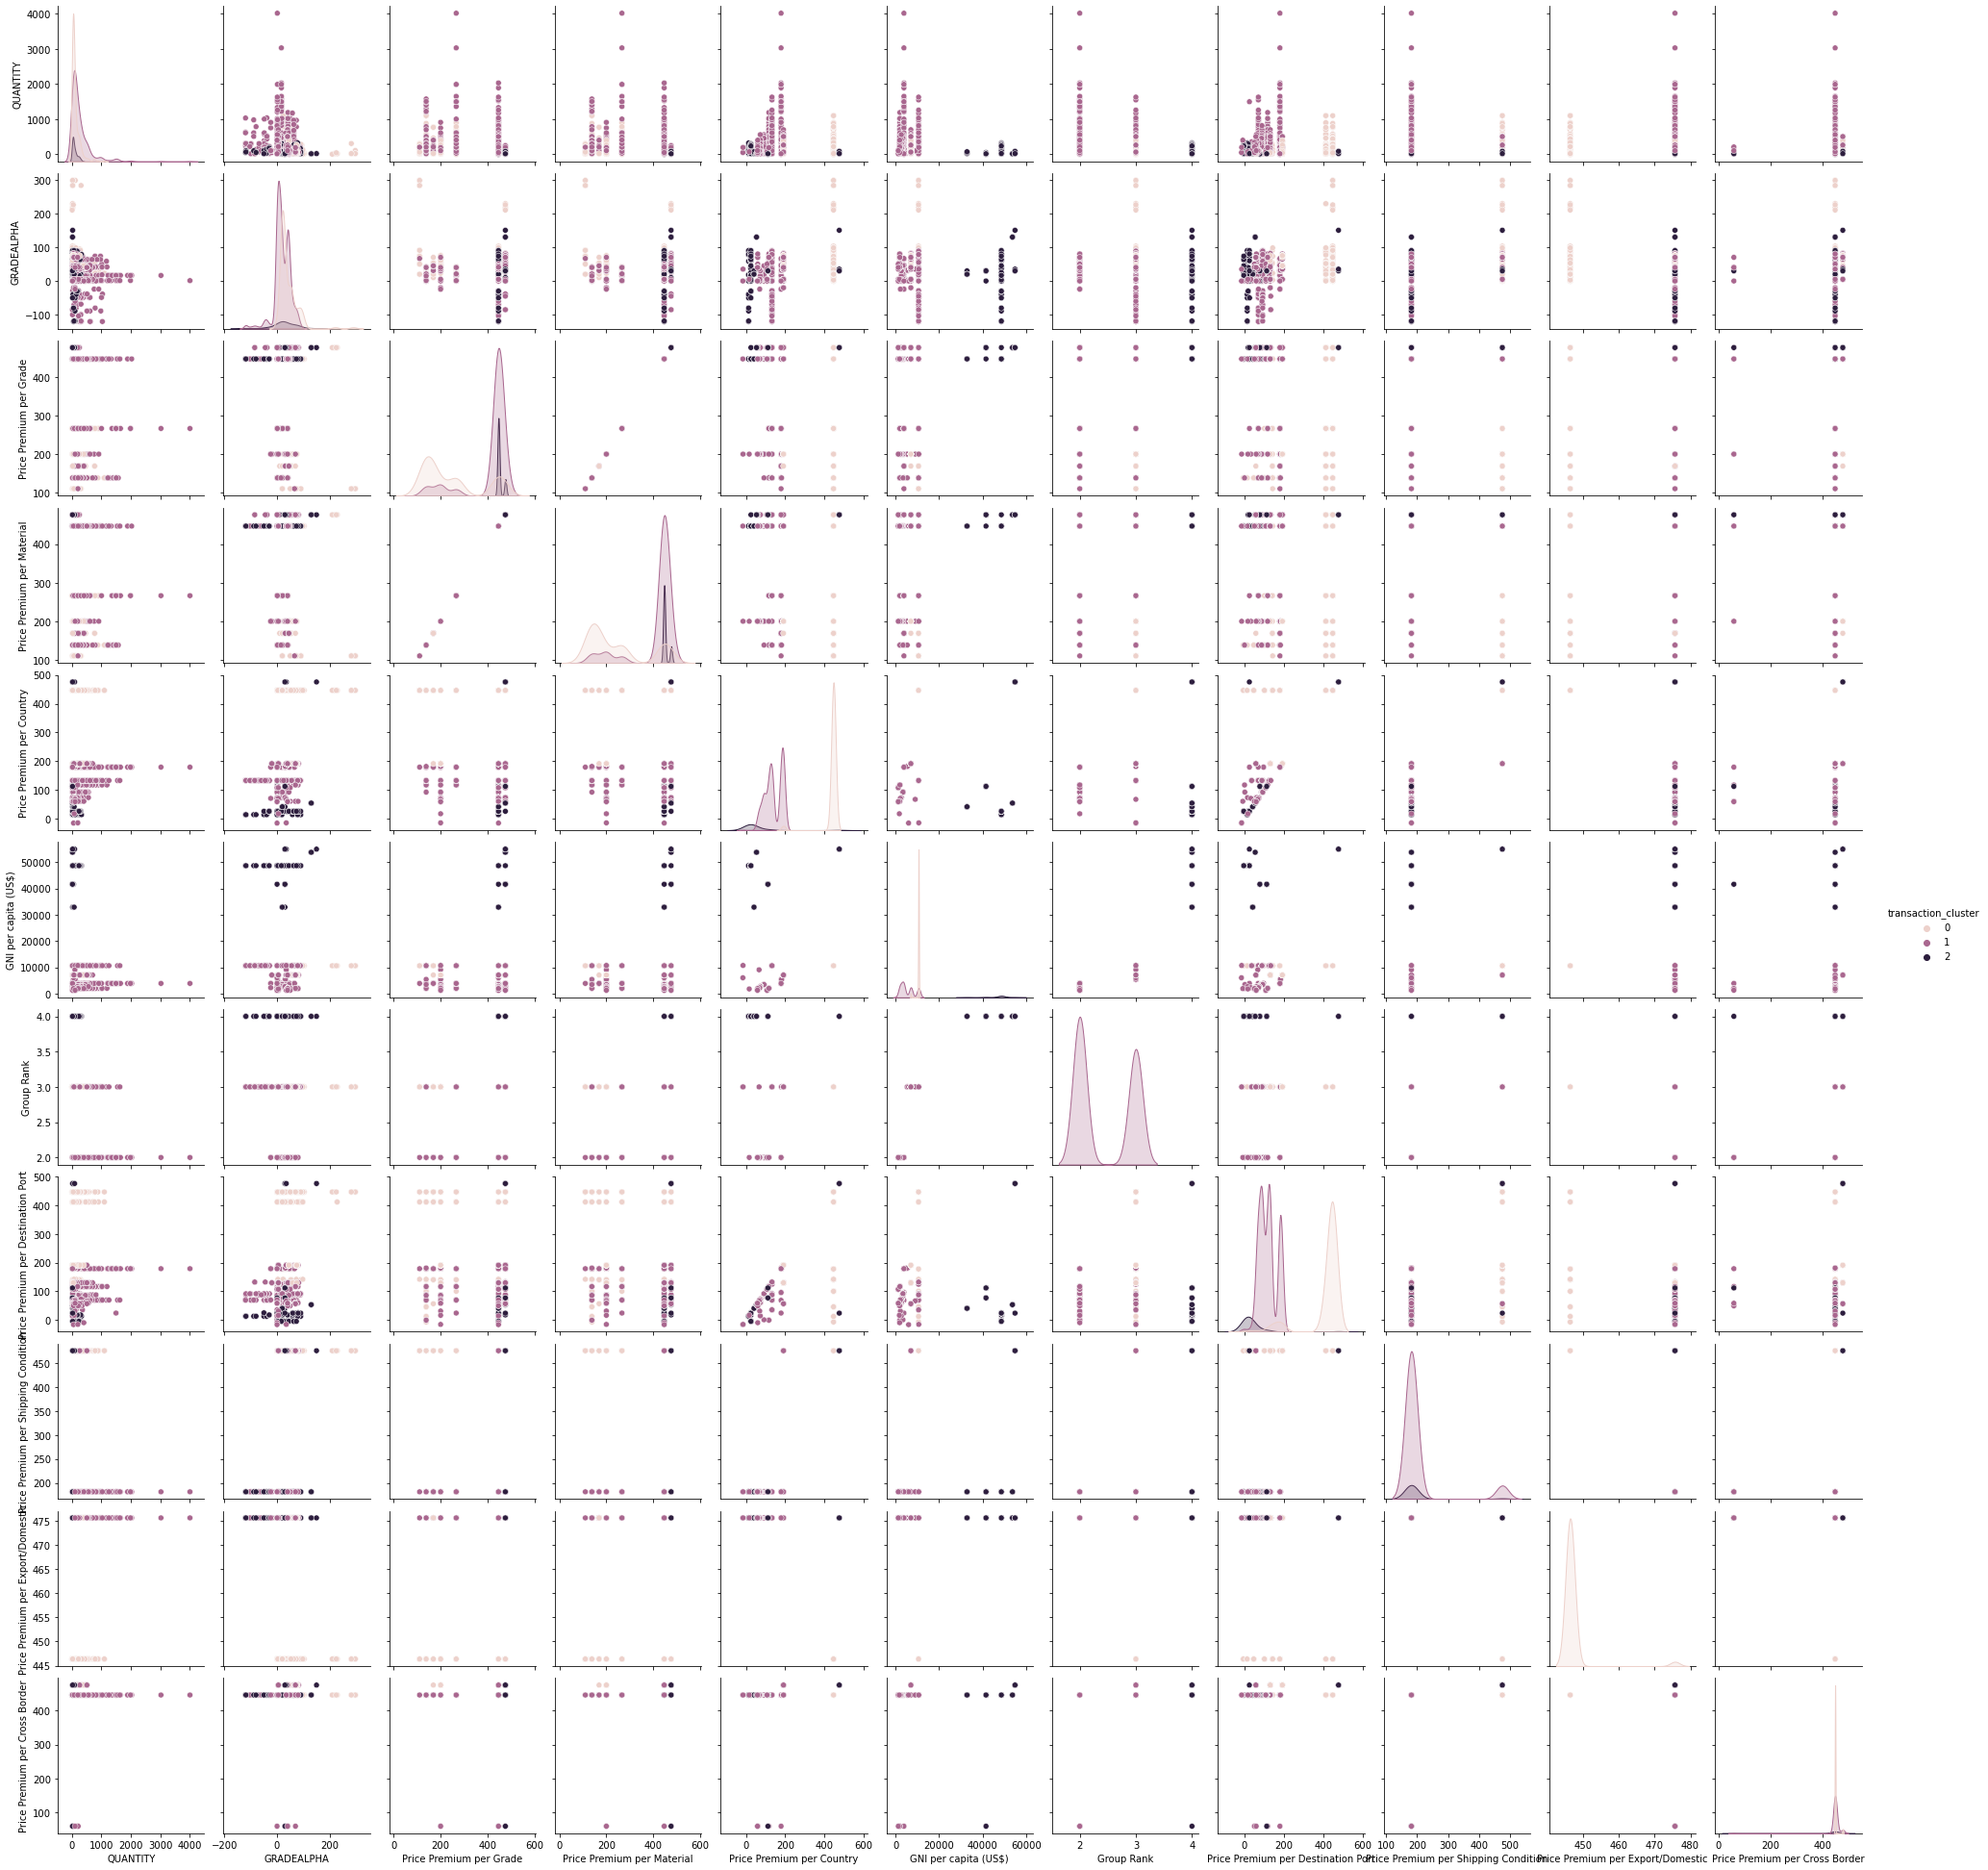

In [99]:
sns.pairplot(X,hue='transaction_cluster')

In [100]:
# X_std_df = pd.DataFrame(X_std,columns=features)
# X_std_df['transaction_cluster'] = clustering.labels_

In [101]:
# sns.pairplot(X_std_df,hue='transaction_cluster')

In [102]:
pca_scale_df['transaction_cluster'] = clustering.labels_

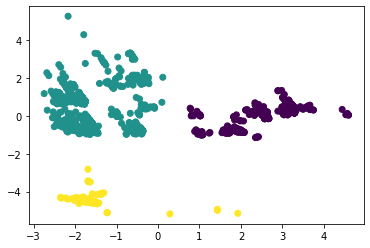

In [103]:
plt.scatter(pca_scale_df['PC_0'],pca_scale_df['PC_1'],c=pca_scale_df['transaction_cluster'])

In [104]:
MinMax = MinMaxScaler()
X_MinMax = MinMax.fit_transform(X[features])
X_MinMax_df = pd.DataFrame(X_MinMax)
X_MinMax_df.columns = features
X_MinMax_df['label'] = clustering.labels_
agg_median = X_MinMax_df.groupby('label').median().reset_index()
agg_median

,label,QUANTITY,GRADEALPHA,Price Premium per Grade,Price Premium per Material,Price Premium per Country,GNI per capita (US$),Group Rank,Price Premium per Destination Port,Price Premium per Shipping Condition,Price Premium per Export/Domestic,Price Premium per Cross Border
0,0,0.011093,0.342775,0.245199,0.245199,0.940373,0.173686,0.5,0.940373,1.0,0.0,0.929708
1,1,0.030413,0.323152,0.919699,0.919699,0.301769,0.048640,0.0,0.269978,0.0,1.0,0.929708
2,2,0.012589,0.341105,0.919699,0.919699,0.083595,0.882780,1.0,0.068804,0.0,1.0,0.929708


In [105]:
transaction_segmentation['Transaction Cluster'] = clustering.labels_

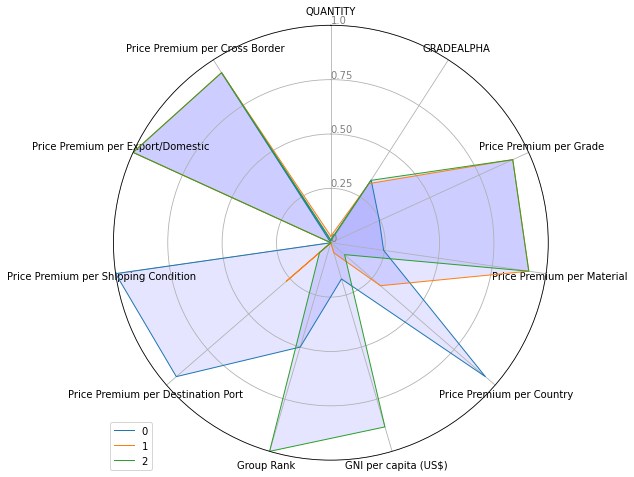

In [106]:
# number of variable
radar_features = features
N_features = len(features)

# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N_features) * 2 * pi for n in range(N_features)]
angles += angles[:1]
    
# Initialise the spider plot
plt.figure(figsize=(36,8))
ax = plt.subplot(111, polar=True)
 
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels
plt.xticks(angles[:-1], radar_features)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([0,0.25,0.50,0.75,1], ["0","0.25","0.50","0.75","1.0"], color="grey", size=10)
plt.ylim(0,1)
 

for label in agg_median['label']:
    
    # Ind
    values=agg_median[agg_median['label']==label][['label']+radar_features]
#     .drop('simple_cluster_4_label').values.flatten().tolist()
    del values['label']
#     values.drop('simple_cluster_4_label')
#     .drop('simple_cluster_4_label').values.flatten().tolist()
#     print(type(values))
    values = values.values.flatten().tolist()
    
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=label)
    ax.fill(angles, values, 'b', alpha=0.1)


# Add legend
plt.legend(loc='best', bbox_to_anchor=(0.1, 0.1))

# Show the graph
plt.show()

In [107]:
transaction_segmentation['Transaction Cluster'].value_counts()

1    1019
0     696
2     102
Name: Transaction Cluster, dtype: int64

In [108]:
transaction_segmentation['Transaction Cluster'].value_counts(normalize=True)

1    0.560815
0    0.383049
2    0.056136
Name: Transaction Cluster, dtype: float64

In [109]:
transaction_segmentation.to_csv('transaction_segmentation_v3B.csv',index=False)

# Price Segmentation

In [110]:
company_segmentation = pd.read_csv('company_segment_v3B.csv')
transaction_segmentation = pd.read_csv('transaction_segmentation_v3B.csv')

In [111]:
data.shape, transaction_segmentation.shape, company_segmentation.shape

((1817, 34), (1817, 44), (148, 4))

In [112]:
company_segmentation.head()

,Sold to Customer Code,Customer Type,Customer Industry,Customer Segment
0,8010000770,End Customer,Mfg-Petroleum Prod,2
1,8010000709,End Customer,Mfg-Petroleum Prod,0
2,8010000645,End Customer,Mfg-Petroleum Prod,0
3,8010000757,End Customer,Mfg-Petroleum Prod,2
4,8010001477,End Customer,Mfg-Petroleum Prod,0


In [113]:
transaction_segmentation.head()

,Contract Execution Date,PMT No.,Item No,Sales Contract No.,Contract/Spot,Sold to Customer Name,Sold to Customer Code,Customer Type,Customer Industry,Grade,Material,Payment Term,Incoterm,Country,Destination Port,City State,Shipping Condition,Export/Domestic,Cross Boarder,Plant,RETA,BL Date,EXCHANGE_RATE,QUANTITY,UOM,Currency,FLOOR_PRICE,NORMALISED_INVOICE_PRICE,REFERENCE_MARKET_PRICE,Price Premium,PRODUCTBASEPRICE,GRADEALPHA,INVOICEPRICE,Price Premium Pctg,Price Premium per Grade,Price Premium per Material,Price Premium per Country,GNI per capita (US$),Group Rank,Price Premium per Destination Port,Price Premium per Shipping Condition,Price Premium per Export/Domestic,Price Premium per Cross Border,Transaction Cluster
0,2017-08-04,QTN-0000012192-1,1,30010898,QUOTATION,DURA-MINE SDN BHD.,8010000770,End Customer,Mfg-Petroleum Prod,HD5301AA,72000544,ZB30,DAP,Malaysia,MYSG00 KLANG VALLEY,MYSG00 KLANG VALLEY,TRUCK PACK(Drum),DOMESTIC,NONCROSSBORDER,M167,2017-08-08,2017-08-01,4.29,22.0,MT,USD,1070.0,1150.98423,1086.25,64.73423,1090.0,20.000000,1177.000000,0.059594,138.64267,138.64267,446.36763,10580.0,3.0,411.46914,475.67398,446.36763,446.36763,0
1,2018-03-07,QTN-0000015960-1,3,30013989,QUOTATION,COMMERCIAL PLASTIC INDUSTRIES,8010000729,Distributor / Trader,Mfg-Petroleum Prod,HD5301AA,72000544,ZM60,DAP,Malaysia,MYSG00 KLANG VALLEY,MYSG00 KLANG VALLEY,TRUCK PACK(Drum),DOMESTIC,NONCROSSBORDER,M167,2018-03-13,2018-03-06,3.90,572.0,MT,USD,1340.0,1403.21349,1401.25,1.96349,1360.0,23.521096,1430.001096,0.001401,138.64267,138.64267,446.36763,10580.0,3.0,411.46914,475.67398,446.36763,446.36763,0
2,2017-09-11,QTN-0000012629-1,1,30011296,QUOTATION,KAMMA KLANG ENTERPRISE SDN BHD,8010000960,End Customer,Mfg-Petroleum Prod,HD5301AA,72000544,ZCBD,DAP,Malaysia,MYSG00 KLANG VALLEY,MYSG00 KLANG VALLEY,TRUCK PACK(Drum),DOMESTIC,NONCROSSBORDER,M167,2017-09-14,2017-09-07,4.29,22.0,MT,USD,1140.0,1189.09195,1135.00,54.09195,1160.0,20.000000,1212.000000,0.047658,138.64267,138.64267,446.36763,10580.0,3.0,411.46914,475.67398,446.36763,446.36763,0
3,2018-03-06,QTN-0000015921-1,4,30013967,QUOTATION,CJ POLYMERS SDN. BHD.,8010000714,Distributor / Trader,Mfg-Petroleum Prod,HD5301AA,72000544,ZB60,DAP,Malaysia,MYSG00 KLANG VALLEY,MYSG00 KLANG VALLEY,TRUCK PACK(Drum),DOMESTIC,NONCROSSBORDER,M167,2018-03-31,2018-03-24,3.90,1100.0,MT,USD,1340.0,1405.06411,1401.25,3.81411,1360.0,21.760548,1430.000548,0.002722,138.64267,138.64267,446.36763,10580.0,3.0,411.46914,475.67398,446.36763,446.36763,0
4,2018-03-08,QTN-0000016042-1,1,30014047,QUOTATION,WT PLASTIC PRODUCTS SDN BHD,8010001548,End Customer,Mfg-Petroleum Prod,HD5301AA,72000544,ZB60,DAP,Malaysia,MYSG00 KLANG VALLEY,MYSG00 KLANG VALLEY,TRUCK PACK(Drum),DOMESTIC,NONCROSSBORDER,M167,2018-03-09,2018-03-02,3.90,726.0,MT,USD,1340.0,1405.06411,1401.25,3.81411,1360.0,21.760548,1430.000548,0.002722,138.64267,138.64267,446.36763,10580.0,3.0,411.46914,475.67398,446.36763,446.36763,0


In [114]:
X = pd.merge(company_segmentation,transaction_segmentation,on=['Sold to Customer Code','Customer Industry','Customer Type'], how='inner')

In [115]:
X.shape

(1817, 45)

In [116]:
X

,Sold to Customer Code,Customer Type,Customer Industry,Customer Segment,Contract Execution Date,PMT No.,Item No,Sales Contract No.,Contract/Spot,Sold to Customer Name,Grade,Material,Payment Term,Incoterm,Country,Destination Port,City State,Shipping Condition,Export/Domestic,Cross Boarder,Plant,RETA,BL Date,EXCHANGE_RATE,QUANTITY,UOM,Currency,FLOOR_PRICE,NORMALISED_INVOICE_PRICE,REFERENCE_MARKET_PRICE,Price Premium,PRODUCTBASEPRICE,GRADEALPHA,INVOICEPRICE,Price Premium Pctg,Price Premium per Grade,Price Premium per Material,Price Premium per Country,GNI per capita (US$),Group Rank,Price Premium per Destination Port,Price Premium per Shipping Condition,Price Premium per Export/Domestic,Price Premium per Cross Border,Transaction Cluster
0,8010000770,End Customer,Mfg-Petroleum Prod,2,2017-08-04,QTN-0000012192-1,1,30010898,QUOTATION,DURA-MINE SDN BHD.,HD5301AA,72000544,ZB30,DAP,Malaysia,MYSG00 KLANG VALLEY,MYSG00 KLANG VALLEY,TRUCK PACK(Drum),DOMESTIC,NONCROSSBORDER,M167,2017-08-08,2017-08-01,4.29,22.00,MT,USD,1070.0,1150.98423,1086.25,64.73423,1090.0,20.0,1177.0,0.059594,138.64267,138.64267,446.36763,10580.0,3.0,411.46914,475.67398,446.36763,446.36763,0
1,8010000770,End Customer,Mfg-Petroleum Prod,2,2017-07-12,QTN-0000011800-1,1,30010584,QUOTATION,DURA-MINE SDN BHD.,HD5301AA,72000544,ZB30,DAP,Malaysia,MYSG00 KLANG VALLEY,MYSG00 KLANG VALLEY,TRUCK PACK(Drum),DOMESTIC,NONCROSSBORDER,M167,2017-07-14,2017-07-07,4.25,44.00,MT,USD,1110.0,1122.00926,1100.00,22.00926,1130.0,20.0,1148.0,0.020008,138.64267,138.64267,446.36763,10580.0,3.0,411.46914,475.67398,446.36763,446.36763,0
2,8010000770,End Customer,Mfg-Petroleum Prod,2,2017-10-05,QTN-0000013133-1,1,30011699,QUOTATION,DURA-MINE SDN BHD.,HD5301AA,72000544,ZB30,DAP,Malaysia,MYSG00 KLANG VALLEY,MYSG00 KLANG VALLEY,TRUCK PACK(Drum),DOMESTIC,NONCROSSBORDER,M167,2017-10-09,2017-10-02,4.20,22.00,MT,USD,1190.0,1264.88585,1193.00,71.88585,1210.0,20.0,1291.0,0.060256,138.64267,138.64267,446.36763,10580.0,3.0,411.46914,475.67398,446.36763,446.36763,0
3,8010000770,End Customer,Mfg-Petroleum Prod,2,2017-09-06,QTN-0000012584-1,1,30011256,QUOTATION,DURA-MINE SDN BHD.,HD5301AA,72000544,ZB30,DAP,Malaysia,MYSG00 KLANG VALLEY,MYSG00 KLANG VALLEY,TRUCK PACK(Drum),DOMESTIC,NONCROSSBORDER,M167,2017-09-30,2017-09-23,4.29,44.00,MT,USD,1140.0,1208.93418,1135.00,73.93418,1160.0,20.0,1235.0,0.065140,138.64267,138.64267,446.36763,10580.0,3.0,411.46914,475.67398,446.36763,446.36763,0
4,8010000770,End Customer,Mfg-Petroleum Prod,2,2018-03-07,QTN-0000015928-1,1,30014021,QUOTATION,DURA-MINE SDN BHD.,HD5301AA,72000544,ZB30,DAP,Malaysia,MYKD01 ALOR SETAR,MYSG00 KLANG VALLEY,TRUCK PACK(Drum),DOMESTIC,NONCROSSBORDER,M167,2018-03-13,2018-03-06,3.90,22.00,MT,USD,1340.0,1504.68304,1401.25,103.43304,1360.0,20.0,1526.0,0.073815,138.64267,138.64267,446.36763,10580.0,3.0,446.36763,475.67398,446.36763,446.36763,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1812,8010007185,Distributor / Trader,Mfg-Others,2,2019-01-23,QTN-0000021929-2,1,30019680,QUOTATION,MEGA VINA COMPANY LIMITED,C150Y,72000448,TT00,CIF,Vietnam,VNSGN HO CHI MINH,NaN,MARINE PACK,EXPORT,NONCROSSBORDER,M169,2019-01-31,NaN,4.16,306.00,MT,USD,1000.0,1001.73466,1040.00,-38.26534,1040.0,5.0,1005.0,-0.036794,446.36763,446.36763,73.00000,2660.0,2.0,60.00000,181.41252,475.67398,446.36763,1
1813,8010007704,No Customer Type,Mfg-Petroleum Prod,0,2020-06-10,QTN-0000031921-1,1,30029481,QUOTATION,HYOSUNG TNC CORPORATION,C150Y,72000448,LC00,CFR,South Korea,KRICE INCHEON,NaN,MARINE PACK,EXPORT,NONCROSSBORDER,M169,2020-06-30,2020-06-23,4.34,49.50,MT,USD,746.0,868.00000,848.00,20.00000,746.0,20.0,870.0,0.023585,446.36763,446.36763,41.00000,32860.0,4.0,41.00000,181.41252,475.67398,446.36763,2
1814,8010007704,No Customer Type,Mfg-Petroleum Prod,0,2020-02-12,QTN-0000029709-1,1,30027268,QUOTATION,HYOSUNG TNC CORPORATION,C150Y,72000448,LC00,CFR,South

In [117]:
final = X[['Customer Segment','Transaction Cluster','Price Premium']]

In [118]:
final.to_csv('final_v3B.csv',index=False)

In [119]:
final['Label'] = 'Company Segment: '+final['Customer Segment'].astype(str)+', Transaction Segment: '+final['Transaction Cluster'].astype(str)

<ipython-input-119-f0ccaa8a8f29>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final['Label'] = 'Company Segment: '+final['Customer Segment'].astype(str)+', Transaction Segment: '+final['Transaction Cluster'].astype(str)


In [120]:
final

,Customer Segment,Transaction Cluster,Price Premium,Label
0,2,0,64.73423,"Company Segment: 2, Transaction Segment: 0"
1,2,0,22.00926,"Company Segment: 2, Transaction Segment: 0"
2,2,0,71.88585,"Company Segment: 2, Transaction Segment: 0"
3,2,0,73.93418,"Company Segment: 2, Transaction Segment: 0"
4,2,0,103.43304,"Company Segment: 2, Transaction Segment: 0"
...,...,...,...,...
1812,2,1,-38.26534,"Company Segment: 2, Transaction Segment: 1"
1813,0,2,20.00000,"Company Segment: 0, Transaction Segment: 2"
1814,0,2,-13.00000,"Company Segment: 0, Transaction Segment: 2"
1815,0,2,-11.00000,"Company Segment: 0, Transaction Segment: 2"


Text(0.5, 1.0, 'Original Output')

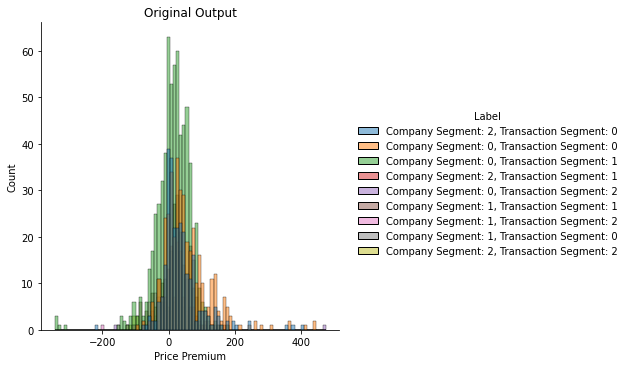

In [121]:
sns.displot(data=final, x="Price Premium", hue="Label",alpha=0.5)
plt.title('Original Output')

Text(0.5, 1.0, 'Original Output')

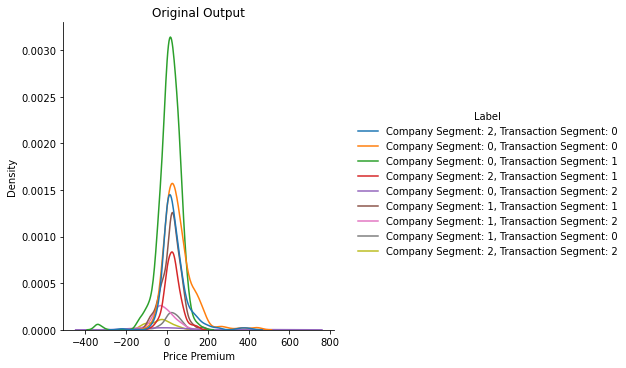

In [122]:
sns.displot(data=final, x="Price Premium", hue="Label",alpha=0.5,kind='kde')
plt.title('Original Output')

The purpose for the manipulation is to reduce the overlap areas across all segments and to remove the outliers.

## Manipulate Final Distribution by Using 5-95 Percentile of Price Premium

In [123]:
X

,Sold to Customer Code,Customer Type,Customer Industry,Customer Segment,Contract Execution Date,PMT No.,Item No,Sales Contract No.,Contract/Spot,Sold to Customer Name,Grade,Material,Payment Term,Incoterm,Country,Destination Port,City State,Shipping Condition,Export/Domestic,Cross Boarder,Plant,RETA,BL Date,EXCHANGE_RATE,QUANTITY,UOM,Currency,FLOOR_PRICE,NORMALISED_INVOICE_PRICE,REFERENCE_MARKET_PRICE,Price Premium,PRODUCTBASEPRICE,GRADEALPHA,INVOICEPRICE,Price Premium Pctg,Price Premium per Grade,Price Premium per Material,Price Premium per Country,GNI per capita (US$),Group Rank,Price Premium per Destination Port,Price Premium per Shipping Condition,Price Premium per Export/Domestic,Price Premium per Cross Border,Transaction Cluster
0,8010000770,End Customer,Mfg-Petroleum Prod,2,2017-08-04,QTN-0000012192-1,1,30010898,QUOTATION,DURA-MINE SDN BHD.,HD5301AA,72000544,ZB30,DAP,Malaysia,MYSG00 KLANG VALLEY,MYSG00 KLANG VALLEY,TRUCK PACK(Drum),DOMESTIC,NONCROSSBORDER,M167,2017-08-08,2017-08-01,4.29,22.00,MT,USD,1070.0,1150.98423,1086.25,64.73423,1090.0,20.0,1177.0,0.059594,138.64267,138.64267,446.36763,10580.0,3.0,411.46914,475.67398,446.36763,446.36763,0
1,8010000770,End Customer,Mfg-Petroleum Prod,2,2017-07-12,QTN-0000011800-1,1,30010584,QUOTATION,DURA-MINE SDN BHD.,HD5301AA,72000544,ZB30,DAP,Malaysia,MYSG00 KLANG VALLEY,MYSG00 KLANG VALLEY,TRUCK PACK(Drum),DOMESTIC,NONCROSSBORDER,M167,2017-07-14,2017-07-07,4.25,44.00,MT,USD,1110.0,1122.00926,1100.00,22.00926,1130.0,20.0,1148.0,0.020008,138.64267,138.64267,446.36763,10580.0,3.0,411.46914,475.67398,446.36763,446.36763,0
2,8010000770,End Customer,Mfg-Petroleum Prod,2,2017-10-05,QTN-0000013133-1,1,30011699,QUOTATION,DURA-MINE SDN BHD.,HD5301AA,72000544,ZB30,DAP,Malaysia,MYSG00 KLANG VALLEY,MYSG00 KLANG VALLEY,TRUCK PACK(Drum),DOMESTIC,NONCROSSBORDER,M167,2017-10-09,2017-10-02,4.20,22.00,MT,USD,1190.0,1264.88585,1193.00,71.88585,1210.0,20.0,1291.0,0.060256,138.64267,138.64267,446.36763,10580.0,3.0,411.46914,475.67398,446.36763,446.36763,0
3,8010000770,End Customer,Mfg-Petroleum Prod,2,2017-09-06,QTN-0000012584-1,1,30011256,QUOTATION,DURA-MINE SDN BHD.,HD5301AA,72000544,ZB30,DAP,Malaysia,MYSG00 KLANG VALLEY,MYSG00 KLANG VALLEY,TRUCK PACK(Drum),DOMESTIC,NONCROSSBORDER,M167,2017-09-30,2017-09-23,4.29,44.00,MT,USD,1140.0,1208.93418,1135.00,73.93418,1160.0,20.0,1235.0,0.065140,138.64267,138.64267,446.36763,10580.0,3.0,411.46914,475.67398,446.36763,446.36763,0
4,8010000770,End Customer,Mfg-Petroleum Prod,2,2018-03-07,QTN-0000015928-1,1,30014021,QUOTATION,DURA-MINE SDN BHD.,HD5301AA,72000544,ZB30,DAP,Malaysia,MYKD01 ALOR SETAR,MYSG00 KLANG VALLEY,TRUCK PACK(Drum),DOMESTIC,NONCROSSBORDER,M167,2018-03-13,2018-03-06,3.90,22.00,MT,USD,1340.0,1504.68304,1401.25,103.43304,1360.0,20.0,1526.0,0.073815,138.64267,138.64267,446.36763,10580.0,3.0,446.36763,475.67398,446.36763,446.36763,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1812,8010007185,Distributor / Trader,Mfg-Others,2,2019-01-23,QTN-0000021929-2,1,30019680,QUOTATION,MEGA VINA COMPANY LIMITED,C150Y,72000448,TT00,CIF,Vietnam,VNSGN HO CHI MINH,NaN,MARINE PACK,EXPORT,NONCROSSBORDER,M169,2019-01-31,NaN,4.16,306.00,MT,USD,1000.0,1001.73466,1040.00,-38.26534,1040.0,5.0,1005.0,-0.036794,446.36763,446.36763,73.00000,2660.0,2.0,60.00000,181.41252,475.67398,446.36763,1
1813,8010007704,No Customer Type,Mfg-Petroleum Prod,0,2020-06-10,QTN-0000031921-1,1,30029481,QUOTATION,HYOSUNG TNC CORPORATION,C150Y,72000448,LC00,CFR,South Korea,KRICE INCHEON,NaN,MARINE PACK,EXPORT,NONCROSSBORDER,M169,2020-06-30,2020-06-23,4.34,49.50,MT,USD,746.0,868.00000,848.00,20.00000,746.0,20.0,870.0,0.023585,446.36763,446.36763,41.00000,32860.0,4.0,41.00000,181.41252,475.67398,446.36763,2
1814,8010007704,No Customer Type,Mfg-Petroleum Prod,0,2020-02-12,QTN-0000029709-1,1,30027268,QUOTATION,HYOSUNG TNC CORPORATION,C150Y,72000448,LC00,CFR,South

In [124]:
dist = X.groupby(['Customer Segment','Transaction Cluster']).aggregate({'Price Premium':[np.min,np.mean,np.median,np.max,np.size,np.std]}).reset_index()
dist.columns = ['_'.join(cols) for cols in dist.columns]
dist.columns = [col.replace('_',' ').strip() for col in dist.columns]
dist

,Customer Segment,Transaction Cluster,Price Premium amin,Price Premium mean,Price Premium median,Price Premium amax,Price Premium size,Price Premium std
0,0,0,-95.42370,55.185344,39.375000,446.36763,386.0,72.259540
1,0,1,-345.00000,13.052002,17.784270,181.41252,662.0,56.680452
2,0,2,-163.65370,17.267067,-11.125000,475.67398,12.0,155.823964
3,1,0,-95.42368,22.719766,20.333320,84.00000,33.0,38.497153
4,1,1,-103.84154,22.335809,25.890200,179.03099,223.0,45.409423
5,1,2,-197.59155,-18.545500,-28.299320,111.98493,61.0,54.639189
6,2,0,-221.32325,37.409490,23.807900,404.50201,277.0,63.484006
7,2,1,-77.89724,27.514309,25.580995,152.78315,134.0,37.782289
8,2,2,-123.22923,-35.956018,-32.593870,53.75726,29.0,52.241523


In [125]:
PricePremiumPercentile = X[['Customer Segment','Transaction Cluster','Price Premium']].groupby(['Customer Segment','Transaction Cluster']).quantile([0.05, 0.95]).reset_index()
PricePremiumPercentile = pd.pivot_table(PricePremiumPercentile, values='Price Premium',index=['Customer Segment','Transaction Cluster'],columns='level_2').reset_index() 
PricePremiumPercentile.columns = ['Customer Segment','Transaction Cluster','Price Premium Lower Bound','Price Premium Upper Bound']
PricePremiumPercentile

,Customer Segment,Transaction Cluster,Price Premium Lower Bound,Price Premium Upper Bound
0,0,0,-26.666670,170.163713
1,0,1,-71.713260,87.950000
2,0,2,-107.711390,257.600316
3,1,0,-38.461680,78.393778
4,1,1,-51.225000,87.952021
5,1,2,-103.462100,62.312880
6,2,0,-30.000000,143.943432
7,2,1,-31.904496,88.101180
8,2,2,-108.775012,53.155344


In [126]:
final_dist = pd.merge(dist,PricePremiumPercentile,on=['Customer Segment','Transaction Cluster'],how='inner')
final_dist

,Customer Segment,Transaction Cluster,Price Premium amin,Price Premium mean,Price Premium median,Price Premium amax,Price Premium size,Price Premium std,Price Premium Lower Bound,Price Premium Upper Bound
0,0,0,-95.42370,55.185344,39.375000,446.36763,386.0,72.259540,-26.666670,170.163713
1,0,1,-345.00000,13.052002,17.784270,181.41252,662.0,56.680452,-71.713260,87.950000
2,0,2,-163.65370,17.267067,-11.125000,475.67398,12.0,155.823964,-107.711390,257.600316
3,1,0,-95.42368,22.719766,20.333320,84.00000,33.0,38.497153,-38.461680,78.393778
4,1,1,-103.84154,22.335809,25.890200,179.03099,223.0,45.409423,-51.225000,87.952021
5,1,2,-197.59155,-18.545500,-28.299320,111.98493,61.0,54.639189,-103.462100,62.312880
6,2,0,-221.32325,37.409490,23.807900,404.50201,277.0,63.484006,-30.000000,143.943432
7,2,1,-77.89724,27.514309,25.580995,152.78315,134.0,37.782289,-31.904496,88.101180
8,2,2,-123.22923,-35.956018,-32.593870,53.75726,29.0,52.241523,-108.775012,53.155344


In [127]:
final_dataset = pd.merge(X,final_dist,on=['Customer Segment','Transaction Cluster'],how='inner')
final_dataset['Label'] = 'Company Segment: '+final_dataset['Customer Segment'].astype(str)+', Transaction Segment: '+final_dataset['Transaction Cluster'].astype(str)
final_dataset

,Sold to Customer Code,Customer Type,Customer Industry,Customer Segment,Contract Execution Date,PMT No.,Item No,Sales Contract No.,Contract/Spot,Sold to Customer Name,Grade,Material,Payment Term,Incoterm,Country,Destination Port,City State,Shipping Condition,Export/Domestic,Cross Boarder,Plant,RETA,BL Date,EXCHANGE_RATE,QUANTITY,UOM,Currency,FLOOR_PRICE,NORMALISED_INVOICE_PRICE,REFERENCE_MARKET_PRICE,Price Premium,PRODUCTBASEPRICE,GRADEALPHA,INVOICEPRICE,Price Premium Pctg,Price Premium per Grade,Price Premium per Material,Price Premium per Country,GNI per capita (US$),Group Rank,Price Premium per Destination Port,Price Premium per Shipping Condition,Price Premium per Export/Domestic,Price Premium per Cross Border,Transaction Cluster,Price Premium amin,Price Premium mean,Price Premium median,Price Premium amax,Price Premium size,Price Premium std,Price Premium Lower Bound,Price Premium Upper Bound,Label
0,8010000770,End Customer,Mfg-Petroleum Prod,2,2017-08-04,QTN-0000012192-1,1,30010898,QUOTATION,DURA-MINE SDN BHD.,HD5301AA,72000544,ZB30,DAP,Malaysia,MYSG00 KLANG VALLEY,MYSG00 KLANG VALLEY,TRUCK PACK(Drum),DOMESTIC,NONCROSSBORDER,M167,2017-08-08,2017-08-01,4.29,22.0,MT,USD,1070.0,1150.98423,1086.250,64.73423,1090.0,20.0,1177.00,0.059594,138.64267,138.64267,446.36763,10580.0,3.0,411.46914,475.67398,446.36763,446.36763,0,-221.32325,37.409490,23.80790,404.50201,277.0,63.484006,-30.000000,143.943432,"Company Segment: 2, Transaction Segment: 0"
1,8010000770,End Customer,Mfg-Petroleum Prod,2,2017-07-12,QTN-0000011800-1,1,30010584,QUOTATION,DURA-MINE SDN BHD.,HD5301AA,72000544,ZB30,DAP,Malaysia,MYSG00 KLANG VALLEY,MYSG00 KLANG VALLEY,TRUCK PACK(Drum),DOMESTIC,NONCROSSBORDER,M167,2017-07-14,2017-07-07,4.25,44.0,MT,USD,1110.0,1122.00926,1100.000,22.00926,1130.0,20.0,1148.00,0.020008,138.64267,138.64267,446.36763,10580.0,3.0,411.46914,475.67398,446.36763,446.36763,0,-221.32325,37.409490,23.80790,404.50201,277.0,63.484006,-30.000000,143.943432,"Company Segment: 2, Transaction Segment: 0"
2,8010000770,End Customer,Mfg-Petroleum Prod,2,2017-10-05,QTN-0000013133-1,1,30011699,QUOTATION,DURA-MINE SDN BHD.,HD5301AA,72000544,ZB30,DAP,Malaysia,MYSG00 KLANG VALLEY,MYSG00 KLANG VALLEY,TRUCK PACK(Drum),DOMESTIC,NONCROSSBORDER,M167,2017-10-09,2017-10-02,4.20,22.0,MT,USD,1190.0,1264.88585,1193.000,71.88585,1210.0,20.0,1291.00,0.060256,138.64267,138.64267,446.36763,10580.0,3.0,411.46914,475.67398,446.36763,446.36763,0,-221.32325,37.409490,23.80790,404.50201,277.0,63.484006,-30.000000,143.943432,"Company Segment: 2, Transaction Segment: 0"
3,8010000770,End Customer,Mfg-Petroleum Prod,2,2017-09-06,QTN-0000012584-1,1,30011256,QUOTATION,DURA-MINE SDN BHD.,HD5301AA,72000544,ZB30,DAP,Malaysia,MYSG00 KLANG VALLEY,MYSG00 KLANG VALLEY,TRUCK PACK(Drum),DOMESTIC,NONCROSSBORDER,M167,2017-09-30,2017-09-23,4.29,44.0,MT,USD,1140.0,1208.93418,1135.000,73.93418,1160.0,20.0,1235.00,0.065140,138.64267,138.64267,446.36763,10580.0,3.0,411.46914,475.67398,446.36763,446.36763,0,-221.32325,37.409490,23.80790,404.50201,277.0,63.484006,-30.000000,143.943432,"Company Segment: 2, Transaction Segment: 0"
4,8010000770,End Customer,Mfg-Petroleum Prod,2,2018-03-07,QTN-0000015928-1,1,30014021,QUOTATION,DURA-MINE SDN BHD.,HD5301AA,72000544,ZB30,DAP,Malaysia,MYKD01 ALOR SETAR,MYSG00 KLANG VALLEY,TRUCK PACK(Drum),DOMESTIC,NONCROSSBORDER,M167,2018-03-13,2018-03-06,3.90,22.0,MT,USD,1340.0,1504.68304,1401.250,103.43304,1360.0,20.0,1526.00,0.073815,138.64267,138.64267,446.36763,10580.0,3.0,446.36763,475.67398,446.36763,446.36763,0,-221.32325,37.409490,23.80790,404.50201,277.0,63.484006,-30.000000,143.943432,"Company Segment: 2, Transaction Segment: 0"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1812,8010000892,Distributor / Trader,Mfg-Petroleum Prod,2,2018-01-09,QTN-0000014654-1,2,30013240,QUOTATION,HOXXON INTERNATIO

Text(0.5, 1.0, 'After Remove Outliers, 5th-95th Percentile')

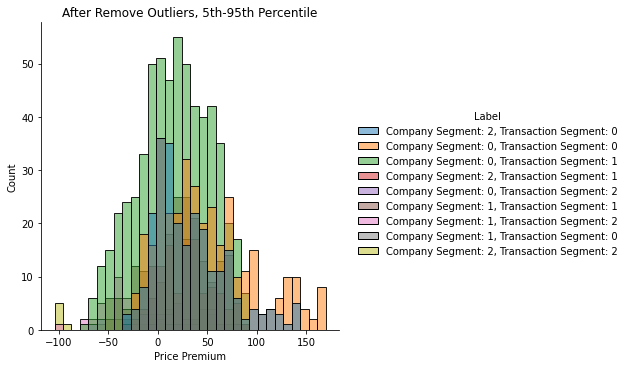

In [128]:
sns.displot(data=final_dataset[ 
                (final_dataset['Price Premium']>=final_dataset['Price Premium Lower Bound']) 
                & (final_dataset['Price Premium']<=final_dataset['Price Premium Upper Bound']) 
            ], x="Price Premium", hue="Label",alpha=0.5)
plt.title('After Remove Outliers, 5th-95th Percentile')

Text(0.5, 1.0, 'After Remove Outliers, 5th-95th Percentile')

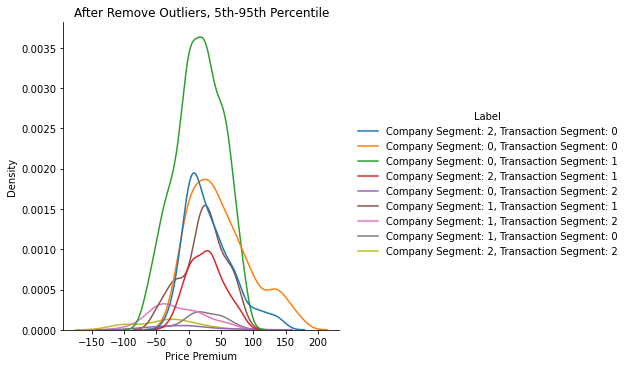

In [129]:
# sns.displot(data=final, x="Price Premium", hue="Label",alpha=0.5,kind='kde')

sns.displot(data=final_dataset[ 
                (final_dataset['Price Premium']>=final_dataset['Price Premium Lower Bound']) 
                & (final_dataset['Price Premium']<=final_dataset['Price Premium Upper Bound']) 
            ], x="Price Premium", hue="Label",alpha=0.5, kind='kde')
plt.title('After Remove Outliers, 5th-95th Percentile')

In [130]:
final_dataset.to_csv('final_dataset_3B.csv',index=False)

In [131]:
final_dataset[ 
                (final_dataset['Price Premium']>=final_dataset['Price Premium Lower Bound']) 
                & (final_dataset['Price Premium']<=final_dataset['Price Premium Upper Bound'])
            ].groupby('Label').aggregate({'Price Premium':[np.median,np.max]})

Price Premium           
                                                  median       amax
Label                                                              
Company Segment: 0, Transaction Segment: 0     38.750000  169.96068
Company Segment: 0, Transaction Segment: 1     17.784270   87.00000
Company Segment: 0, Transaction Segment: 2    -11.125000   79.17641
Company Segment: 1, Transaction Segment: 0     20.333320   77.23175
Company Segment: 1, Transaction Segment: 1     25.890200   87.52021
Company Segment: 1, Transaction Segment: 2    -28.299320   62.31288
Company Segment: 2, Transaction Segment: 0     23.782430  142.17929
Company Segment: 2, Transaction Segment: 1     25.580995   86.11578
Company Segment: 2, Transaction Segment: 2    -32.593870   52.25247

# Note

- The outliers management could be done in the earlier stage 